# Analyse BlueSeis BSPF Events

In [1]:
import os
import obspy as obs
import matplotlib.pyplot as plt
import numpy as np

from obspy.clients.fdsn import Client

from functions.request_data import __request_data
from functions.compute_adr_pfo import __compute_adr_pfo
from functions.compute_beamforming_pfo import __compute_beamforming_pfo

In [2]:
if os.uname().nodename == 'lighthouse':
    root_path = '/home/andbro/'
    data_path = '/home/andbro/kilauea-data/'
    archive_path = '/home/andbro/freenas/'
elif os.uname().nodename == 'kilauea':
    root_path = '/home/brotzer/'
    data_path = '/import/kilauea-data/'
    archive_path = '/import/freenas-ffb-01-data/'

## Configurations

In [3]:
config = {}

## output path for figures
config['path_to_figs'] = data_path+"BSPF/figures/M41_event/"


## BSPF coordinates
config['BSPF_lon'] = -116.455439
config['BSPF_lat'] = 33.610643

name = "M41"
config['tbeg'] = obs.UTCDateTime("2022-12-31 12:12:20")
config['tend'] = obs.UTCDateTime("2022-12-31 12:12:55")

# config['fmin'] = 1
# config['fmax'] = 5.0

## Load Data

In [4]:
event = Client("USGS").get_events(starttime=config['tbeg'], endtime=config['tend'], minmagnitude=4.0)
event = event[0]

## Eventtime
config['eventtime'] = event.origins[0].time


from obspy.geodetics.base import gps2dist_azimuth

dist, az, baz = gps2dist_azimuth(event.origins[0].latitude, event.origins[0].longitude,
                                 config['BSPF_lat'], config['BSPF_lon'],
                                 )
dist/1000, az, baz

/tmp/ipykernel_615246/169804072.py:10: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  dist, az, baz = gps2dist_azimuth(event.origins[0].latitude, event.origins[0].longitude,


(24.334569833387384, 346.2992112316263, 166.2649290568653)

## Load Waveforms

In [5]:
from functions.get_stream import __get_stream

In [6]:
# st0 = __get_stream(config['tbeg'], config['tend'])

# st0.write("./data/event41_6c.mseed", format="MSEED")

# st0.plot(equal_scale=False);

In [7]:
st0 = obs.read("./data/event41_6c.mseed")

st0.trim(st0[0].stats.starttime+5, st0[0].stats.endtime)

submask = "mi"

bspf0 = st0.select(station="BSPF").copy()
pfo0 = st0.select(station="PFO*").copy()
adr0 = st0.select(station="RPFO", location=submask[:2]).copy()

if submask == "in":
    config['fmin'], config['fmax'] = 1.0, 6.0
elif submask == "mi":
    config['fmin'], config['fmax'] = 0.5, 1.0
elif submask == "al":
    config['fmin'], config['fmax'] = 0.1, 0.5


15 Trace(s) in Stream:
II.PFO.10.BHE  | 2022-12-31T12:12:24.994538Z - 2022-12-31T12:12:54.994538Z | 40.0 Hz, 1201 samples
II.PFO.10.BHN  | 2022-12-31T12:12:24.994538Z - 2022-12-31T12:12:54.994538Z | 40.0 Hz, 1201 samples
II.PFO.10.BHZ  | 2022-12-31T12:12:24.994538Z - 2022-12-31T12:12:54.994538Z | 40.0 Hz, 1201 samples
II.RPFO.al.BJE | 2022-12-31T12:12:24.996349Z - 2022-12-31T12:12:54.996349Z | 40.0 Hz, 1201 samples
II.RPFO.al.BJN | 2022-12-31T12:12:24.996349Z - 2022-12-31T12:12:54.996349Z | 40.0 Hz, 1201 samples
II.RPFO.al.BJZ | 2022-12-31T12:12:24.996349Z - 2022-12-31T12:12:54.996349Z | 40.0 Hz, 1201 samples
II.RPFO.in.BJE | 2022-12-31T12:12:24.995468Z - 2022-12-31T12:12:54.995468Z | 40.0 Hz, 1201 samples
II.RPFO.in.BJN | 2022-12-31T12:12:24.995468Z - 2022-12-31T12:12:54.995468Z | 40.0 Hz, 1201 samples
II.RPFO.in.BJZ | 2022-12-31T12:12:24.995468Z - 2022-12-31T12:12:54.995468Z | 40.0 Hz, 1201 samples
II.RPFO.mi.BJE | 2022-12-31T12:12:24.996005Z - 2022-12-31T12:12:54.996005Z | 40.0 Hz, 

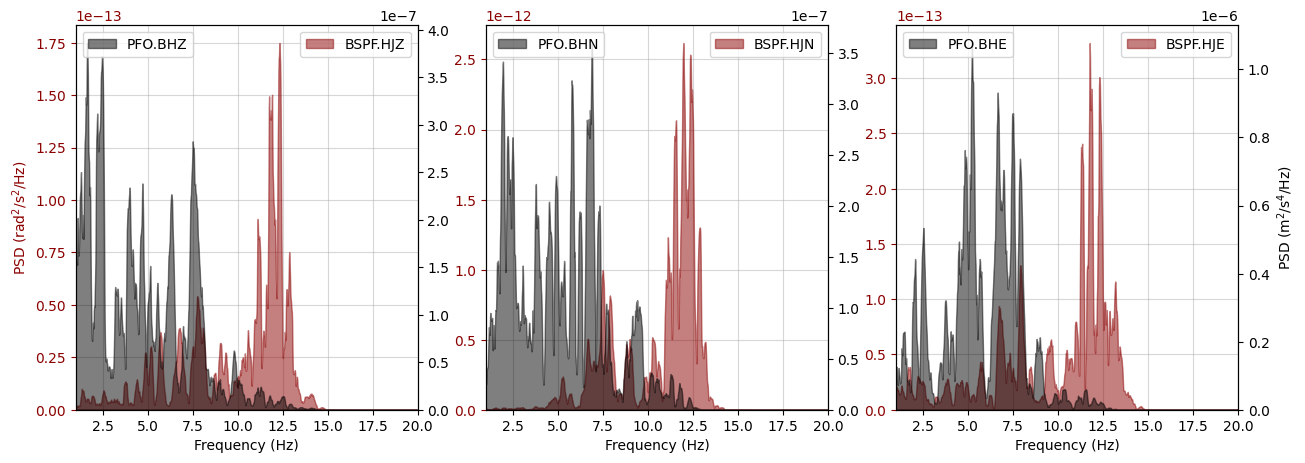

In [8]:
from functions.makeplot_spectra_comparison_fill import __makeplot_spectra_comparison_fill

acc = st0.select(station="PFO*").copy()
rot = st0.select(station="BSPF").copy()

rot = rot.detrend("simple")
acc = acc.detrend("simple")

fmin, fmax = 1, 20


fig = __makeplot_spectra_comparison_fill(rot, acc, fmin=fmin, fmax=fmax, ylog=False, xlog=False, fill=True)

fig.savefig(config['path_to_figs']+f"BSPF_{name}_spectra_all_{fmin}_{fmax}.png", format="png", dpi=150, bbox_inches='tight');


## Create stream for all data

In [9]:
from functions.makeplot_waveform_comparison_all import __makeplot_waveform_comparison_all

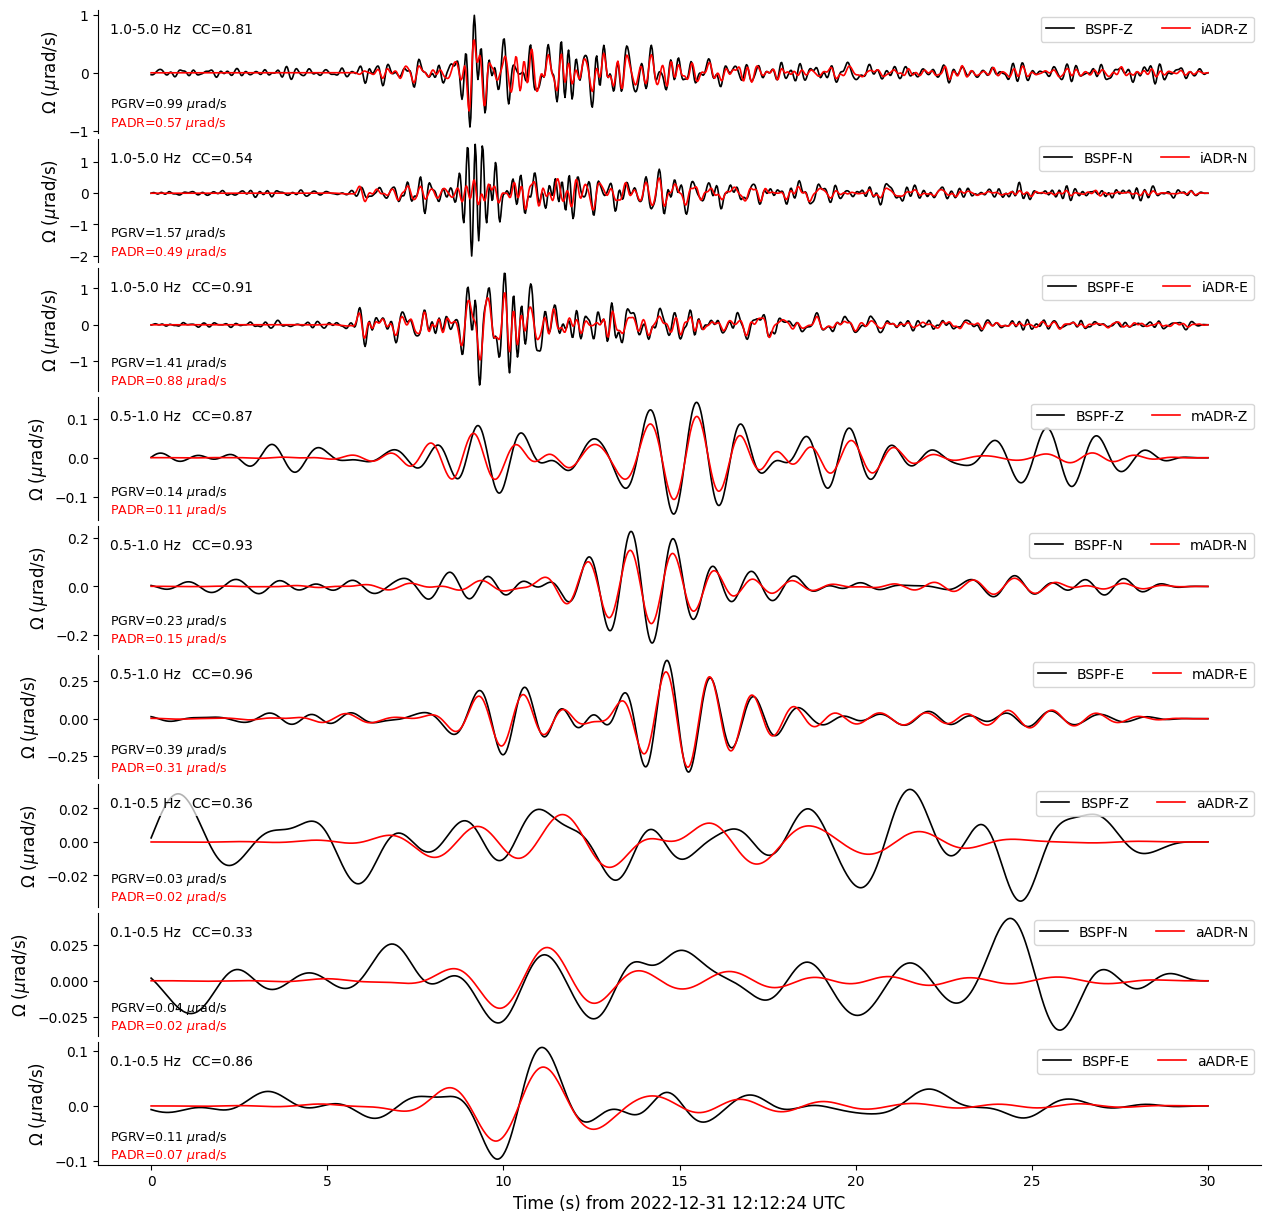

In [10]:
fig = __makeplot_waveform_comparison_all(st0);

fig.savefig(config['path_to_figs']+f"BSPF_{name}_waveforms_all.png", format="png", dpi=150, bbox_inches='tight');


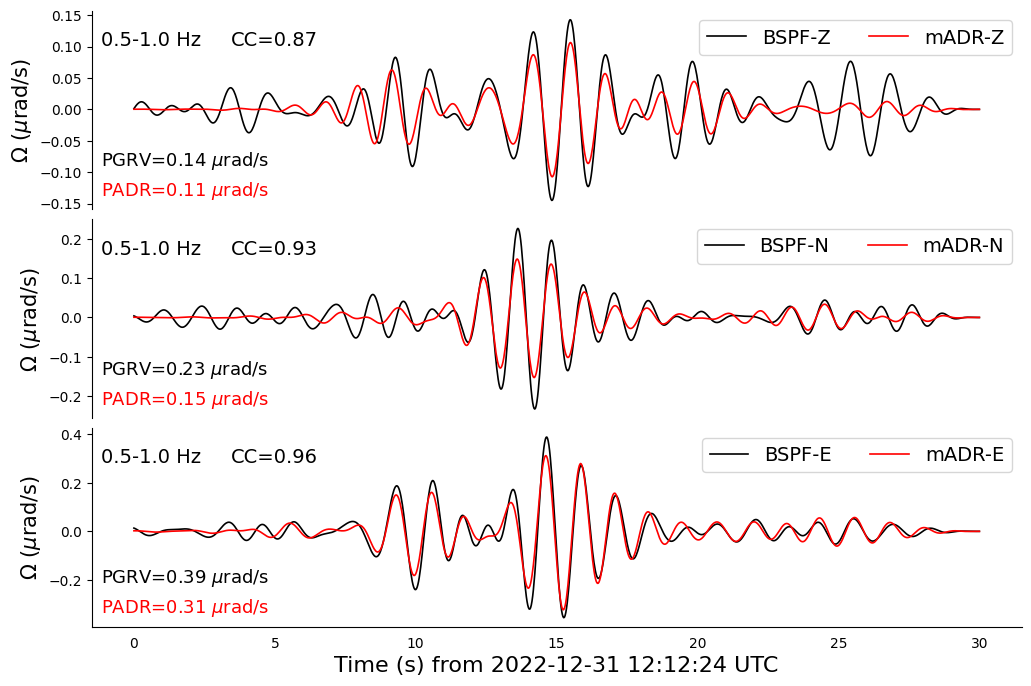

In [97]:
def __makeplot_waveform_comparison(st_in):

    from obspy.signal.cross_correlation import correlate
    import numpy as np
    import matplotlib.pyplot as plt

    st = st_in.copy()

    # st = st.trim(st[0].stats.starttime+5, st[0].stats.endtime-15).copy()

    fig, ax = plt.subplots(3, 1, figsize=(12, 8), sharex=True)

    lw = 1.2

    font = 16

    fbands = {"in":(1.0, 5.0), "mi":(0.5, 1.0), "al":(0.1, 0.5)}

    offset = [0, 0, 0]

    plt.subplots_adjust(hspace=0.05)

    scaling, unit = 1e6, f"$\mu$rad/s"

    idx = 0
    for _m, array in enumerate(["mi"]):

        fband = fbands[array]

        _adr = st.select(location=array).copy()
        _bspf = st.select(station="BSPF").copy()

        _bspf = _bspf.detrend("simple").taper(0.01).filter("bandpass", freqmin=fband[0], freqmax=fband[1], corners=4, zerophase=True)
        _adr = _adr.detrend("simple").taper(0.01).filter("bandpass", freqmin=fband[0], freqmax=fband[1], corners=4, zerophase=True)

        for _k, comp in enumerate(["Z", "N", "E"]):

            ax[idx].plot(_bspf.select(channel=f"*{comp}")[0].times(), _bspf.select(channel=f"*{comp}")[0].data*scaling, label=f"BSPF-{comp}", color="k", lw=lw)
            ax[idx].plot(_adr.select(channel=f"*{comp}")[0].times(), _adr.select(channel=f"*{comp}")[0].data*scaling, label=f"{array[0]}ADR-{comp}", color="r", lw=lw)

            cc = round(correlate(_bspf.select(channel=f"*{comp}")[0].data, _adr.select(channel=f"*{comp}")[0].data, 0, demean=True, normalize='naive', method='auto')[0], 2)

            # rmse = np.round( np.sqrt( np.mean( ( ( _adr.select(channel=f"*{comp}")[0].data - _bspf.select(channel=f"*{comp}")[0].data )*scaling )**2 ) ), 3)

            ## pick peak rotation velocity
            pgrv = round(np.amax(_bspf.select(channel=f"*{comp}")[0].data*scaling), 2)

            ## pick peak adr
            padr = round(np.amax(_adr.select(channel=f"*{comp}")[0].data*scaling), 2)


            t1 = ax[idx].text(0.01, 0.9, f"{fband[0]}-{fband[1]} Hz", ha='left', va='top', transform=ax[idx].transAxes, fontsize=font-2)
            t1.set_bbox(dict(facecolor='white', alpha=0.7, linewidth=0))
            t2 = ax[idx].text(0.15, 0.9, f"CC={cc}", ha='left', va='top', transform=ax[idx].transAxes, fontsize=font-2)
            t2.set_bbox(dict(facecolor='white', alpha=0.7, linewidth=0))
            t3 = ax[idx].text(0.01, 0.30, f"PGRV={pgrv} {unit}", ha='left', va='top', transform=ax[idx].transAxes, fontsize=font-3)
            t3.set_bbox(dict(facecolor='white', alpha=0., linewidth=0))
            t4 = ax[idx].text(0.01, 0.15, f"PADR={padr} {unit}", ha='left', color="r", va='top', transform=ax[idx].transAxes, fontsize=font-3)
            t4.set_bbox(dict(facecolor='white', alpha=0., linewidth=0))

            ax[idx].legend(loc=1, ncols=4, fontsize=font-2)

            # ax[idx].grid(which="both", alpha=0.5)

            ax[idx].set_ylabel(f"$\Omega$ ({unit})", fontsize=font)
            ax[idx].xaxis.label.set_size(font-1)
            ax[idx].yaxis.label.set_size(font-1)

            if idx < 8:
                ax[idx].tick_params(axis='x', bottom=False)

            for pos in ["right", "top", "bottom"]:
                ax[idx].spines[pos].set_visible(False)

            idx += 1

    ax[idx-1].spines["bottom"].set_visible(True)

    ax[idx-1].set_xlabel(f"Time (s) from {st_in[0].stats.starttime.date} {str(st_in[0].stats.starttime.time).split('.')[0]} UTC", fontsize=font)

    # ax[0].set_title(f"{config['tbeg'].date} | {config['fmin']}-{config['fmax']} Hz | ADR {submask} | CC$_Z$ = {cc_Z} | CC$_N$ = {cc_N} | CC$_E$ = {cc_E}")

    plt.show();
    return fig

fig = __makeplot_waveform_comparison(st0);

fig.savefig(config['path_to_figs']+f"BSPF_{name}_waveforms_single.png", format="png", dpi=150, bbox_inches='tight');


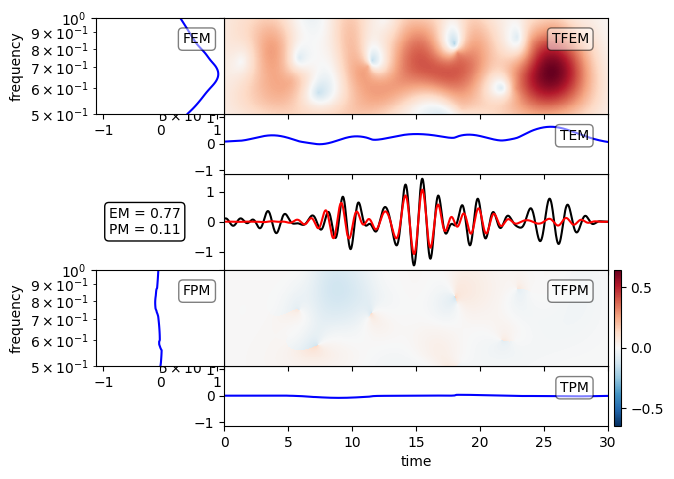

In [12]:
from scipy.signal import hilbert
from obspy.signal.tf_misfit import plot_tf_misfits

component = "Z"
array = "mi"

fmin, fmax = 0.5, 1.0

st1 = st0.copy()

st1 = st1.detrend("demean").taper(0.01, type="cosine").filter("bandpass", freqmin=fmin, freqmax=fmax, corners=4, zerophase=True)

# st = st.trim(config['tbeg']+15, config['tend']-10)

s1 = st1.select(station="BSPF", channel=f"*{component}")[0].data
s2 = st1.select(station="RPFO", location=array, channel=f"*{component}")[0].data
# s2 = st1.select(station="PFOIX", channel="*T")[0].data

dt = st1[0].stats.delta


plot_tf_misfits(s1, s2, dt=dt, fmin=fmin, fmax=fmax, show=True, norm="global")


In [13]:
acc = st0.select(station="PFO*").copy()
rot = st0.select(station="BSPF").copy()

for tr in acc:
    if "Z" in tr.stats.channel:
        tr.data *= -1


fmin, fmax = 0.5, 1.0
# fmin, fmax = 1.0, 6.0

rot = rot.detrend("demean").taper(0.01, type="cosine").filter("bandpass", freqmin=fmin, freqmax=fmax, corners=4, zerophase=True)
acc = acc.detrend("demean").taper(0.01, type="cosine").filter("bandpass", freqmin=fmin, freqmax=fmax, corners=4, zerophase=True)

acc.trim(config['tbeg']+9, config['tend']-5)
rot.trim(config['tbeg']+9, config['tend']-5)

3 Trace(s) in Stream:
II.PFO.10.BHE | 2022-12-31T12:12:28.994538Z - 2022-12-31T12:12:49.994538Z | 40.0 Hz, 841 samples
II.PFO.10.BHN | 2022-12-31T12:12:28.994538Z - 2022-12-31T12:12:49.994538Z | 40.0 Hz, 841 samples
II.PFO.10.BHZ | 2022-12-31T12:12:28.994538Z - 2022-12-31T12:12:49.994538Z | 40.0 Hz, 841 samples

3 Trace(s) in Stream:
PY.BSPF..HJE | 2022-12-31T12:12:28.998700Z - 2022-12-31T12:12:49.998700Z | 40.0 Hz, 841 samples
PY.BSPF..HJN | 2022-12-31T12:12:28.998700Z - 2022-12-31T12:12:49.998700Z | 40.0 Hz, 841 samples
PY.BSPF..HJZ | 2022-12-31T12:12:28.998800Z - 2022-12-31T12:12:49.998800Z | 40.0 Hz, 841 samples

In [14]:
def __makeplot_waveform_comparison2(rot0, acc0, baz):

    from obspy.signal.cross_correlation import correlate
    from obspy.signal.rotate import rotate_ne_rt
    from numpy import linspace

    rot = rot0.copy()
    acc = acc0.copy()

    fig, ax = plt.subplots(2, 1, figsize=(15, 5), sharex=True)

    acc_scaling, acc_unit = 1e3, f"mm/s$^2$"
    rot_scaling, rot_unit = 1e6, f"$\mu$rad/s"

    lw = 1

    font = 12

    acc_z = acc.select(channel="*Z")[0].data
    rot_z = -rot.select(channel="*Z")[0].data

    acc_r, acc_t = rotate_ne_rt(acc.select(channel="*N")[0].data, acc.select(channel="*E")[0].data, baz)
    rot_r, rot_t = rotate_ne_rt(rot.select(channel="*N")[0].data, rot.select(channel="*E")[0].data, baz)

    ax[0].plot(rot.select(channel="*Z")[0].times(), rot_z*rot_scaling, label="-1*ROT-Z", color="k", lw=lw)
    ax00 = ax[0].twinx()
    ax00.plot(acc.select(channel="*Z")[0].times(), acc_t*acc_scaling, label="ACC-T", color="red", lw=lw)

    ax[1].plot(rot.select(channel="*N")[0].times(), rot_t*rot_scaling, label="ROT-T", color="k", lw=lw)
    ax11 = ax[1].twinx()
    ax11.plot(acc.select(channel="*Z")[0].times(), acc_z*acc_scaling, label="ACC-Z", color="red", lw=lw)

    ax11.set_ylim(-3, 3)

    cc1 = round(correlate(rot_z, acc_t, 0, demean=True, normalize='naive', method='auto')[0], 2)
    cc2 = round(correlate(rot_t, acc_z, 0, demean=True, normalize='naive', method='auto')[0], 2)
    cc = [cc1, cc2]

    ## sync twinx
    ax[0].set_yticks(linspace(ax[0].get_yticks()[0], ax[0].get_yticks()[-1], len(ax[0].get_yticks())))
    ax00.set_yticks(linspace(ax00.get_yticks()[0], ax00.get_yticks()[-1], len(ax[0].get_yticks())))

    ax[1].set_yticks(linspace(ax[1].get_yticks()[0], ax[1].get_yticks()[-1], len(ax[1].get_yticks())))
    ax11.set_yticks(linspace(ax11.get_yticks()[0], ax11.get_yticks()[-1], len(ax[1].get_yticks())))

    for i in range(2):
        ax[i].legend(loc=1, ncols=4)
        ax[i].grid(which="both", alpha=0.5)
        ax[i].set_ylabel(f"$\Omega$ ({rot_unit})", fontsize=font)
        ax[i].text(0.05, 0.9, f"CC={cc[i]}", ha='left', va='top', transform=ax[i].transAxes, fontsize=font-1)

    for _ax in [ax00, ax11]:
        _ax.legend(loc=4)
        _ax.set_ylabel(f"$a$ ({acc_unit})", fontsize=font)

    ax[1].set_xlabel("Time (s)", fontsize=font)

    tbeg = acc[0].stats.starttime
    ax[0].set_title(f"{tbeg.date} {str(tbeg.time).split('.')[0]} UTC  |  f = {fmin}-{fmax} Hz  |  BAz = {round(baz, 1)}°  |  ED = {round(dist/1000,1)} km")


    plt.show();
    return fig

# fig = __makeplot_waveform_comparison2(rot, acc, baz)


In [15]:
def __makeplot_waveform_comparison3(rot0, acc0, baz):

    from obspy.signal.cross_correlation import correlate
    from obspy.signal.rotate import rotate_ne_rt
    from numpy import linspace

    rot = rot0.copy()
    acc = acc0.copy()

    fig, ax = plt.subplots(3, 1, figsize=(15, 6), sharex=True)

    acc_scaling, acc_unit = 1e3, f"mm/s$^2$"
    rot_scaling, rot_unit = 1e6, f"$\mu$rad/s"

    lw = 1

    font = 12

    acc_z = acc.select(channel="*Z")[0].data
    rot_z = rot.select(channel="*Z")[0].data

    acc_r, acc_t = rotate_ne_rt(acc.select(channel="*N")[0].data, acc.select(channel="*E")[0].data, baz)
    rot_r, rot_t = rotate_ne_rt(rot.select(channel="*N")[0].data, rot.select(channel="*E")[0].data, baz)

    rot_z*=rot_scaling
    rot_r*=rot_scaling
    rot_t*=rot_scaling

    acc_z*=acc_scaling
    acc_r*=acc_scaling
    acc_t*=acc_scaling

    acc_z_max = max([abs(min(acc_z)), abs(max(acc_z))])
    acc_r_max = max([abs(min(acc_r)), abs(max(acc_r))])
    acc_t_max = max([abs(min(acc_t)), abs(max(acc_t))])

    rot_z_max = max([abs(min(rot_z)), abs(max(rot_z))])
    rot_r_max = max([abs(min(rot_r)), abs(max(rot_r))])
    rot_t_max = max([abs(min(rot_t)), abs(max(rot_t))])


    ax[0].plot(rot.select(channel="*Z")[0].times(), rot_z, label="ROT-Z", color="tab:red", lw=lw, zorder=3)
    ax00 = ax[0].twinx()
    ax00.plot(acc.select(channel="*Z")[0].times(), -acc_t, label="-1*ACC-T", color="black", lw=lw)

    ax[0].set_ylim(-rot_z_max, rot_z_max)
    ax00.set_ylim(-acc_t_max, acc_t_max)

    ax[1].plot(rot.select(channel="*N")[0].times(), rot_t, label="ROT-T", color="tab:red", lw=lw, zorder=3)
    ax11 = ax[1].twinx()
    ax11.plot(acc.select(channel="*Z")[0].times(), acc_z, label="ACC-Z", color="black", lw=lw)

    ax[1].set_ylim(-rot_t_max, rot_t_max)
    ax11.set_ylim(-acc_z_max, acc_z_max)

    ax[2].plot(rot.select(channel="*N")[0].times(), rot_z, label="ROT-Z", color="tab:red", lw=lw, zorder=3)
    ax22 = ax[2].twinx()
    ax22.plot(acc.select(channel="*Z")[0].times(), -acc_r, label="-1*ACC-R", color="black", lw=lw)

    ax[2].set_ylim(-rot_z_max, rot_z_max)
    ax22.set_ylim(-acc_r_max, acc_r_max)

    cc1 = round(correlate(rot_z, -acc_t, 0, demean=True, normalize='naive', method='auto')[0], 2)
    cc2 = round(correlate(rot_t, acc_z, 0, demean=True, normalize='naive', method='auto')[0], 2)
    cc3 = round(correlate(rot_z, -acc_r, 0, demean=True, normalize='naive', method='auto')[0], 2)
    cc = [cc1, cc2, cc3]

    ## sync twinx
    ax[0].set_yticks(linspace(ax[0].get_yticks()[0], ax[0].get_yticks()[-1], len(ax[0].get_yticks())))
    ax00.set_yticks(linspace(ax00.get_yticks()[0], ax00.get_yticks()[-1], len(ax[0].get_yticks())))

    ax[1].set_yticks(linspace(ax[1].get_yticks()[0], ax[1].get_yticks()[-1], len(ax[1].get_yticks())))
    ax11.set_yticks(linspace(ax11.get_yticks()[0], ax11.get_yticks()[-1], len(ax[1].get_yticks())))

    ax[2].set_yticks(linspace(ax[2].get_yticks()[0], ax[2].get_yticks()[-1], len(ax[2].get_yticks())))
    ax22.set_yticks(linspace(ax22.get_yticks()[0], ax22.get_yticks()[-1], len(ax[2].get_yticks())))

    for i in range(3):
        ax[i].legend(loc=1, ncols=4)
        ax[i].grid(which="both", alpha=0.5)
        ax[i].set_ylabel(f"$\Omega$ ({rot_unit})", fontsize=font)
        ax[i].text(0.05, 0.9, f"CC={cc[i]}", ha='left', va='top', transform=ax[i].transAxes, fontsize=font-1)

    for _ax in [ax00, ax11, ax22]:
        _ax.legend(loc=4)
        _ax.set_ylabel(f"$a$ ({acc_unit})", fontsize=font)

    ax[2].set_xlabel("Time (s)", fontsize=font)

    tbeg = acc[0].stats.starttime
    ax[0].set_title(f"{tbeg.date} {str(tbeg.time).split('.')[0]} UTC  |  f = {fmin}-{fmax} Hz  |  BAz = {round(baz, 1)}°  |  ED = {round(dist/1000,1)} km")


    plt.show();
    return fig

# fig = __makeplot_waveform_comparison3(rot, acc, baz)


In [16]:
def __makeplot_waveform_comparison_cc(rot0, acc0, baz, fmin, fmax, distance=None, twin_sec=5, twin_overlap=0.5):

    from obspy.signal.cross_correlation import correlate
    from obspy.signal.rotate import rotate_ne_rt
    from numpy import linspace, ones
    import matplotlib.pyplot as plt

    def __cross_correlation_windows(arr1, arr2, dt, Twin, overlap=0, lag=0, demean=True, plot=False):

        from obspy.signal.cross_correlation import correlate, xcorr_max
        from numpy import arange, array, roll

        N = len(arr1)
        n_interval = int(Twin/dt)
        n_overlap = int(overlap*Twin/dt)

        # time = arange(0, N*dt, dt)

        times, samples = [], []
        n1, n2 = 0, n_interval
        while n2 <= N:
            samples.append((n1, n2))
            times.append(int(n1+(n2-n1)/2)*dt)
            n1 = n1 + n_interval - n_overlap
            n2 = n2 + n_interval - n_overlap

        cc = []
        for _n, (n1, n2) in enumerate(samples):

            _arr1 = roll(arr1[n1:n2], lag)
            _arr2 = arr2[n1:n2]
            ccf = correlate(_arr1, _arr2, 0, demean=demean, normalize='naive', method='fft')
            shift, val = xcorr_max(ccf, abs_max=False)
            cc.append(val)

        return array(times), array(cc)


    rot = rot0.copy()
    acc = acc0.copy()

    Nrow, Ncol = 3, 1

    fig, ax = plt.subplots(Nrow, Ncol, figsize=(15, 6), sharex=True)

    acc_scaling, acc_unit = 1e3, f"mm/s$^2$"
    rot_scaling, rot_unit = 1e6, f"$\mu$rad/s"

    lw = 1

    font = 12

    acc_z = acc.select(channel="*Z")[0].data
    rot_z = rot.select(channel="*Z")[0].data

    acc_r, acc_t = rotate_ne_rt(acc.select(channel="*N")[0].data, acc.select(channel="*E")[0].data, baz)
    rot_r, rot_t = rotate_ne_rt(rot.select(channel="*N")[0].data, rot.select(channel="*E")[0].data, baz)

    rot_z*=rot_scaling
    rot_r*=rot_scaling
    rot_t*=rot_scaling

    acc_z*=acc_scaling
    acc_r*=acc_scaling
    acc_t*=acc_scaling

    acc_z_max = max([abs(min(acc_z)), abs(max(acc_z))])
    acc_r_max = max([abs(min(acc_r)), abs(max(acc_r))])
    acc_t_max = max([abs(min(acc_t)), abs(max(acc_t))])

    rot_z_max = max([abs(min(rot_z)), abs(max(rot_z))])
    rot_r_max = max([abs(min(rot_r)), abs(max(rot_r))])
    rot_t_max = max([abs(min(rot_t)), abs(max(rot_t))])

    dt = rot[0].stats.delta

    rot0 ,acc0, rot0_lbl, acc0_lbl = rot_z, acc_t, "ROT-Z", "ACC-T"
    rot1 ,acc1, rot1_lbl, acc1_lbl = rot_t, acc_z, "ROT_T", "ACC-Z"
    rot2 ,acc2, rot2_lbl, acc2_lbl = rot_z, -acc_r, "ROT-Z", "-1xACC-R"

    tt0, cc0 = __cross_correlation_windows(rot0 ,acc0, dt, twin_sec, overlap=twin_overlap, lag=0, demean=True)
    tt1, cc1 = __cross_correlation_windows(rot1, acc1, dt, twin_sec, overlap=twin_overlap, lag=0, demean=True)
    tt2, cc2 = __cross_correlation_windows(rot2, acc2, dt, twin_sec, overlap=twin_overlap, lag=0, demean=True)

    cmap = plt.get_cmap("coolwarm", 12)


    ax[0].plot(rot.select(channel="*Z")[0].times(), rot0, label=rot0_lbl, color="tab:red", lw=lw, zorder=3)
    ax00 = ax[0].twinx()
    ax00.plot(acc.select(channel="*Z")[0].times(), acc0, label=acc0_lbl, color="black", lw=lw)
    ax01 = ax[0].twinx()
    cm = ax01.scatter(tt0, ones(len(tt0))*-0.9, c=cc0, alpha=abs(cc0), cmap=cmap, label="")

    ax[0].set_ylim(-rot_z_max, rot_z_max)
    ax00.set_ylim(-acc_t_max, acc_t_max)
    ax01.set_ylim(-1, 1)
    ax01.yaxis.set_visible(False)

    ax[1].plot(rot.select(channel="*N")[0].times(), rot1, label=rot1_lbl, color="tab:red", lw=lw, zorder=3)
    ax11 = ax[1].twinx()
    ax11.plot(acc.select(channel="*Z")[0].times(), acc1, label=acc1_lbl, color="black", lw=lw)
    ax12 = ax[1].twinx()
    ax12.scatter(tt1, ones(len(tt1))*-0.9, c=cc1, alpha=abs(cc1), cmap=cmap, label="")

    ax[1].set_ylim(-rot_t_max, rot_t_max)
    ax11.set_ylim(-acc_z_max, acc_z_max)
    ax12.set_ylim(-1, 1)
    ax12.yaxis.set_visible(False)

    ax[2].plot(rot.select(channel="*N")[0].times(), rot2, label=rot2_lbl, color="tab:red", lw=lw, zorder=3)
    ax22 = ax[2].twinx()
    ax22.plot(acc.select(channel="*Z")[0].times(), acc2, label=acc2_lbl, color="black", lw=lw)
    ax23 = ax[2].twinx()
    ax23.scatter(tt2, ones(len(tt2))*-0.9, c=cc2, alpha=abs(cc2), cmap=cmap, label="")

    ax[2].set_ylim(-rot_z_max, rot_z_max)
    ax22.set_ylim(-acc_r_max, acc_r_max)
    ax23.set_ylim(-1, 1)
    ax23.yaxis.set_visible(False)

    cc0 = round(correlate(rot0, acc0, 0, demean=True, normalize='naive', method='auto')[0], 2)
    cc1 = round(correlate(rot1, acc1, 0, demean=True, normalize='naive', method='auto')[0], 2)
    cc2 = round(correlate(rot2, acc2, 0, demean=True, normalize='naive', method='auto')[0], 2)
    cc = [cc0, cc1, cc2]

    ## sync twinx
    ax[0].set_yticks(linspace(ax[0].get_yticks()[0], ax[0].get_yticks()[-1], len(ax[0].get_yticks())))
    ax00.set_yticks(linspace(ax00.get_yticks()[0], ax00.get_yticks()[-1], len(ax[0].get_yticks())))

    ax[1].set_yticks(linspace(ax[1].get_yticks()[0], ax[1].get_yticks()[-1], len(ax[1].get_yticks())))
    ax11.set_yticks(linspace(ax11.get_yticks()[0], ax11.get_yticks()[-1], len(ax[1].get_yticks())))

    ax[2].set_yticks(linspace(ax[2].get_yticks()[0], ax[2].get_yticks()[-1], len(ax[2].get_yticks())))
    ax22.set_yticks(linspace(ax22.get_yticks()[0], ax22.get_yticks()[-1], len(ax[2].get_yticks())))

    for i in range(3):
        ax[i].legend(loc=1, ncols=4)
        ax[i].grid(which="both", alpha=0.5)
        ax[i].set_ylabel(f"$\Omega$ ({rot_unit})", fontsize=font)
        ax[i].text(0.05, 0.9, f"CC={cc[i]}", ha='left', va='top', transform=ax[i].transAxes, fontsize=font-1)

    for _ax in [ax00, ax11, ax22]:
        _ax.legend(loc=4)
        _ax.set_ylabel(f"$a$ ({acc_unit})", fontsize=font)

    ax[2].set_xlabel("Time (s)", fontsize=font)

    tbeg = acc[0].stats.starttime
    ax[0].set_title(f"{tbeg.date} {str(tbeg.time).split('.')[0]} UTC  |  f = {fmin}-{fmax} Hz  |  BAz = {round(baz, 1)}°  |  ED = {round(distance/1000,1)} km  |  T = {twin_sec}s ({int(100*twin_overlap)}%)")

    cax = ax[Nrow-1].inset_axes([0.8, -0.35, 0.2, 0.1], transform=ax[Nrow-1].transAxes)
    cb = plt.colorbar(cm, cax=cax, shrink=0.4, location='bottom', orientation='horizontal')
    cm.set_clim(-1, 1)
    cb.set_label("Cross-Correlation", fontsize=font, loc="left", labelpad=-43, color="black", backgroundcolor="w")

    plt.show();
    return fig

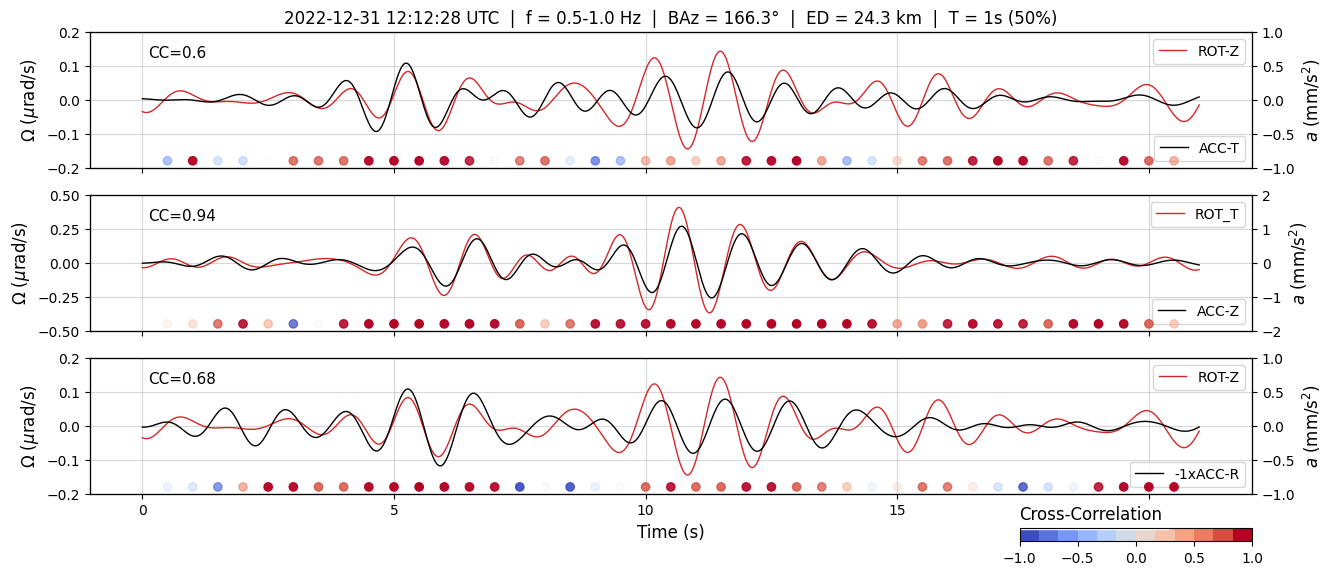

In [17]:
fig = __makeplot_waveform_comparison_cc(rot, acc, baz, fmin, fmax, dist, twin_sec=1, twin_overlap=0.5)

# fig.savefig(config['path_to_figs']+f"BSPF_M42_waveforms_cc.png", format="png", dpi=150, bbox_inches='tight');


In [18]:
from functions.cross_correlation_windows import __cross_correlation_windows
from functions.cross_correlation_function_windows import __cross_correlation_function_windows

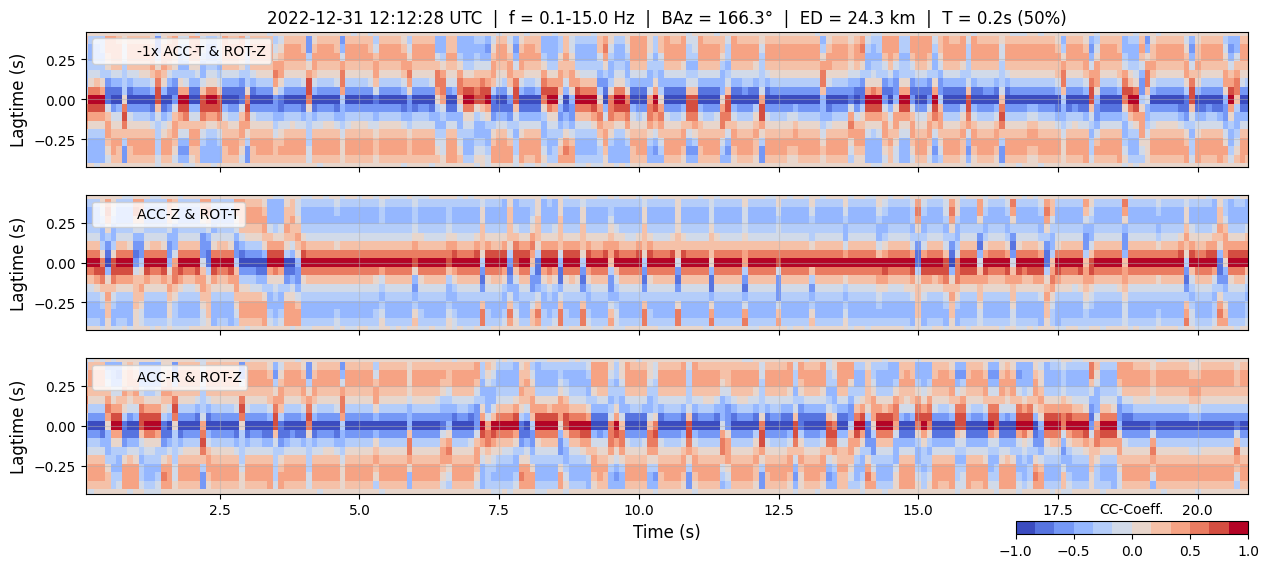

In [82]:
def __makeplot_comparison_ccf(rot0, acc0, baz, twin_sec=5, twin_overlap=0.5, fmin=None, fmax=None):

    from obspy.signal.cross_correlation import correlate
    from obspy.signal.rotate import rotate_ne_rt
    from numpy import linspace

    def __cross_correlation_function_windows(arr1, arr2, dt, Twin, overlap=0, demean=True):

        from obspy.signal.cross_correlation import correlate, xcorr_max
        from numpy import arange, array, roll, linspace

        N = len(arr1)
        n_interval = int(Twin/dt)
        n_overlap = int(overlap*Twin/dt)

        # time = arange(0, N*dt, dt)

        times, samples = [], []
        n1, n2 = 0, n_interval
        while n2 <= N:
            samples.append((n1, n2))
            times.append(int(n1+(n2-n1)/2)*dt)
            n1 = n1 + n_interval - n_overlap
            n2 = n2 + n_interval - n_overlap

        cc, mm, ss = [], [], []
        for _n, (n1, n2) in enumerate(samples):

            _arr1 = arr1[n1:n2]
            _arr2 = arr2[n1:n2]

            num = len(_arr1)

            ccf = correlate(_arr1, _arr2, num, demean=demean, normalize='naive', method='fft')
            shift, val = xcorr_max(ccf)

            cc.append(ccf)
            mm.append(val)
            ss.append(shift)

        num = int(len(cc[0]))
        tlags = linspace(-num*dt, num*dt, num)

        return array(times), array(cc), tlags, array(ss), array(mm)

    rot = rot0.copy()
    acc = acc0.copy()

    Nrow, Ncol = 3, 1

    fig, ax = plt.subplots(Nrow, Ncol, figsize=(15, 6), sharex=True)

    acc_scaling, acc_unit = 1e3, f"mm/s$^2$"
    rot_scaling, rot_unit = 1e6, f"$\mu$rad/s"

    lw = 1

    font = 12

    acc_z = acc.select(channel="*Z")[0].data
    rot_z = rot.select(channel="*Z")[0].data

    acc_r, acc_t = rotate_ne_rt(acc.select(channel="*N")[0].data, acc.select(channel="*E")[0].data, baz)
    rot_r, rot_t = rotate_ne_rt(rot.select(channel="*N")[0].data, rot.select(channel="*E")[0].data, baz)

    rot_z*=rot_scaling
    rot_r*=rot_scaling
    rot_t*=rot_scaling

    acc_z*=acc_scaling
    acc_r*=acc_scaling
    acc_t*=acc_scaling

    acc_z_max = max([abs(min(acc_z)), abs(max(acc_z))])
    acc_r_max = max([abs(min(acc_r)), abs(max(acc_r))])
    acc_t_max = max([abs(min(acc_t)), abs(max(acc_t))])

    rot_z_max = max([abs(min(rot_z)), abs(max(rot_z))])
    rot_r_max = max([abs(min(rot_r)), abs(max(rot_r))])
    rot_t_max = max([abs(min(rot_t)), abs(max(rot_t))])

    dt = rot[0].stats.delta


    cmap = plt.get_cmap("coolwarm", 12)

    ttt0, ccf0, tlags0, shifts0, maxima0 = __cross_correlation_function_windows(-acc_t, rot_z, dt, twin_sec, overlap=twin_overlap, demean=True)
    ttt1, ccf1, tlags1, shifts1, maxima1 = __cross_correlation_function_windows(acc_z, rot_t, dt, twin_sec, overlap=twin_overlap, demean=True)
    ttt2, ccf2, tlags2, shifts2, maxima2 = __cross_correlation_function_windows(acc_r, rot_z, dt, twin_sec, overlap=twin_overlap, demean=True)


    cm0 = ax[0].pcolormesh(ttt0, tlags0, ccf0.T, rasterized=True, vmin=-1, vmax=1, cmap=cmap)
    ax[0].set_ylim(min(tlags0), max(tlags0))
    ax[0].set_xlim(min(ttt0), max(ttt0))
    ax[0].scatter(ttt0, shifts0*dt, s=2, color="k", alpha=0., zorder=4, label="-1x ACC-T & ROT-Z")

    ax[1].pcolormesh(ttt1, tlags1, ccf1.T, rasterized=True, vmin=-1, vmax=1, cmap=cmap)
    ax[1].set_ylim(min(tlags1), max(tlags1))
    ax[1].set_xlim(min(ttt1), max(ttt1))
    ax[1].scatter(ttt1, shifts1*dt, s=2, color="k", alpha=0., zorder=4, label="ACC-Z & ROT-T")

    ax[2].pcolormesh(ttt2, tlags2, ccf2.T, rasterized=True, vmin=-1, vmax=1, cmap=cmap)
    ax[2].set_ylim(min(tlags2), max(tlags2))
    ax[2].set_xlim(min(ttt2), max(ttt2))
    ax[2].scatter(ttt2, shifts2*dt, s=2, color="k", alpha=0., zorder=4, label="ACC-R & ROT-Z")


    for i in range(3):
        ax[i].legend(loc=2, ncols=4)
        ax[i].grid(which="both", alpha=0.5)
        ax[i].set_ylabel(f"Lagtime (s)", fontsize=font)

    ax[2].set_xlabel("Time (s)", fontsize=font)

    tbeg = acc[0].stats.starttime
    ax[0].set_title(f"{tbeg.date} {str(tbeg.time).split('.')[0]} UTC  |  f = {fmin}-{fmax} Hz  |  BAz = {round(baz, 1)}°  |  ED = {round(dist/1000,1)} km  |  T = {twin_sec}s ({int(100*twin_overlap)}%)")

    ## add colorbar
    cax = ax[Nrow-1].inset_axes([0.8, -0.3, 0.2, 0.1], transform=ax[Nrow-1].transAxes)
    cb = plt.colorbar(cm0, cax=cax, shrink=0.4, location='bottom', orientation='horizontal')
    cm0.set_clim(-1, 1)
    cb.set_label("CC-Coeff.", labelpad=-40)

    plt.show();
    return fig

fig = __makeplot_comparison_ccf(rot, acc, baz, twin_sec=0.2, twin_overlap=0.5, fmin=fmin, fmax=fmax)


In [20]:
def __cc_lag_matrix(dat1, dat2, dt, twin_sec, T_lag_sec, dT_lag_sec, plot=False):

    L, dL = int(T_lag_sec/dt), int(dT_lag_sec/dt)

    Tlags = np.arange(-T_lag_sec, T_lag_sec+dT_lag_sec, dT_lag_sec)
    Nlags = np.arange(-L, L+dL, dL)

    for _k, lag in enumerate(Nlags):

        tt, cc = __cross_correlation_windows(dat1, dat2, dt, twin_sec, overlap=0.5, lag=lag, demean=True)

        if _k == 0:
            ccc = np.zeros((len(Nlags), len(cc)))

        ccc[_k] = cc

    if plot:
        plt.figure(figsize=(15, 5))

        cmap = plt.get_cmap("seismic")

        plt.pcolormesh(tt/86400, Tlags, ccc, vmin=-1, vmax=1, cmap=cmap)
        plt.ylabel("Lag Time (sec)")
        plt.xlabel("Time (days)")

        plt.show();

    return tt, Tlags, ccc

In [21]:
from functions.makeplot_spectra_comparison_fill import __makeplot_spectra_comparison_fill

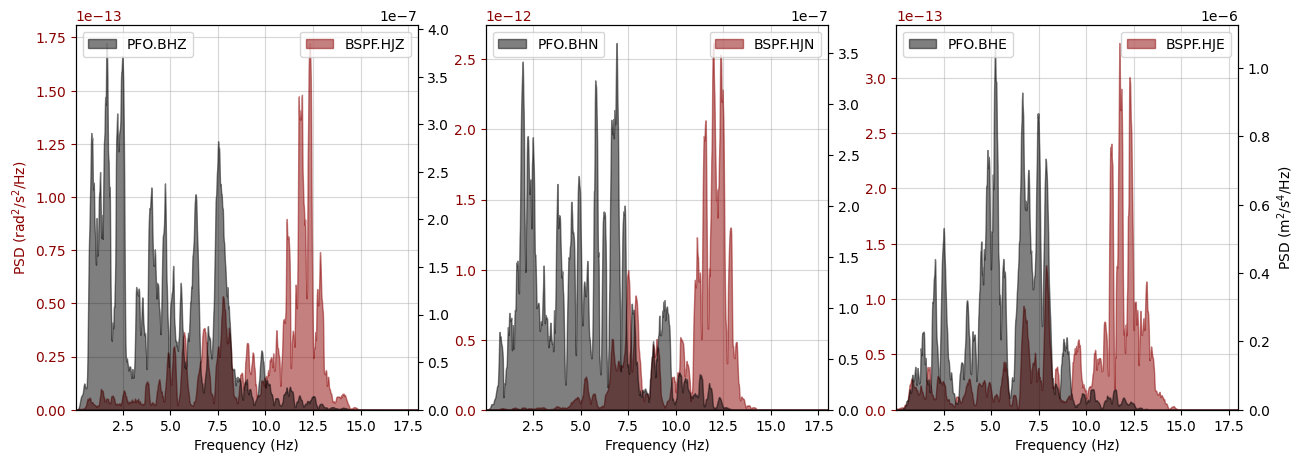

In [22]:
acc0 = st0.select(station="PFO*").copy()
rot0 = st0.select(station="BSPF").copy()

fig = __makeplot_spectra_comparison_fill(rot0, acc0, fmin=0.01, fmax=18, ylog=False, xlog=False, fill=True)

fig.savefig(config['path_to_figs']+f"BSPF_{name}_spectra_all_fill.png", format="png", dpi=150, bbox_inches='tight');


### Wavelet Comparsion

In [23]:
from functions.compute_cwt import __compute_cwt

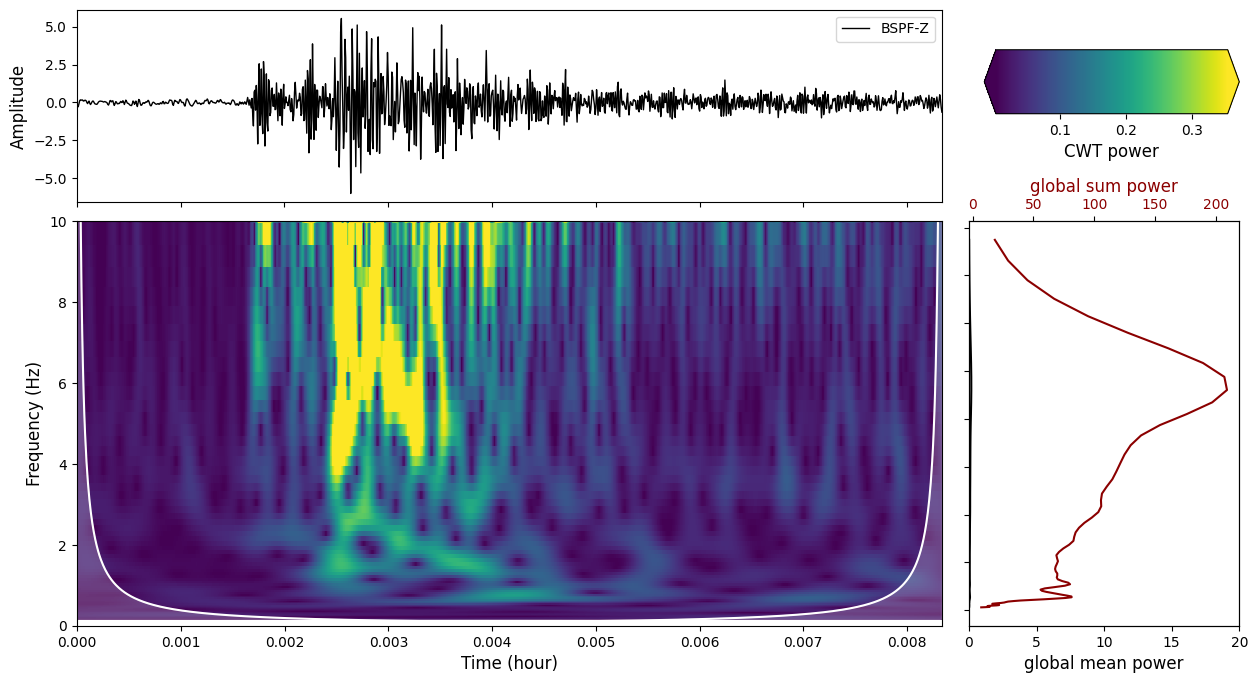

In [24]:
component = "Z"

acc0 = st0.select(station="PFO*").copy()
rot0 = st0.select(station="BSPF").copy()

ttt = rot0[0].times()
arr = rot0.select(channel=f"*{component}")[0].data
dt = rot0[0].stats.delta # seconds

out = __compute_cwt(ttt, arr, dt, tscale="hour",
                    datalabel=f"BSPF-{component}",
                    period=False,
                    fmax=10,
                    plot=True,
                   )

out['fig'].savefig(config['path_to_figs']+f"BSPF_{name}_cwt_{component}.png", format="png", dpi=150, bbox_inches='tight');


## Backazimuth Estimate

In [37]:
from functions.compute_backazimuth import __compute_backazimuth
from functions.get_theoretical_backazimuth import __get_theoretical_backazimuth
from functions.compute_backazimuth_tangent import __compute_backazimuth_tangent
from functions.compare_backazimuth_codes import __compare_backazimuth_codes

In [59]:
config['station_longitude'] = config['BSPF_lon']
config['station_latitude']  = config['BSPF_lat']

## specify window length for baz estimation in seconds
config['win_length_sec'] = 1/fmin

## define an overlap for the windows in percent (50 -> 50%)
config['overlap'] = 75

## specify steps for degrees of baz
config['step'] = 1


config['event'] = event

baz, az, dist = __get_theoretical_backazimuth(config['BSPF_lat'], config['BSPF_lon'], event_obj=event, fdsn_client='USGS')

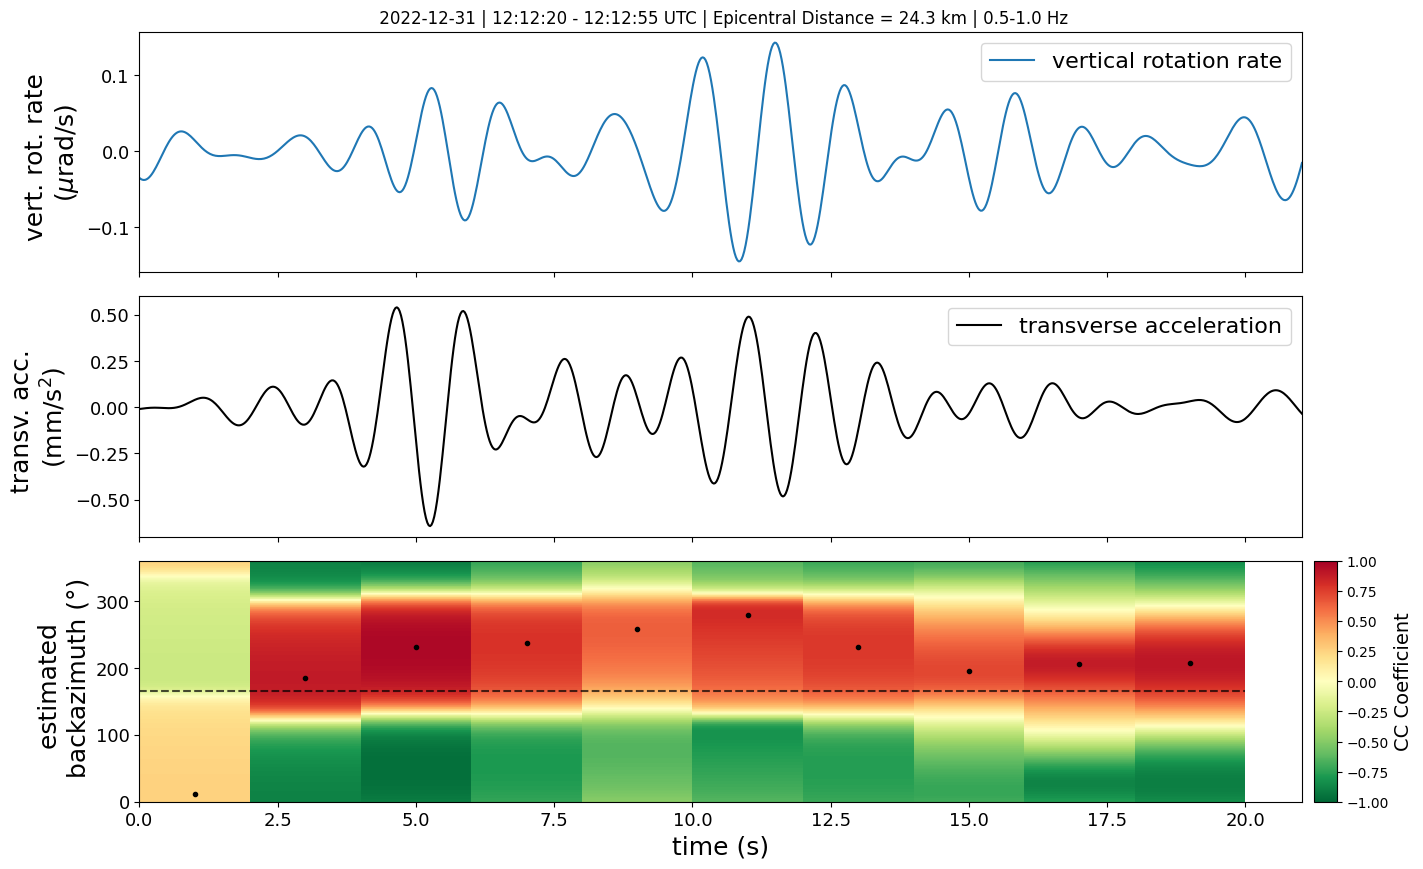

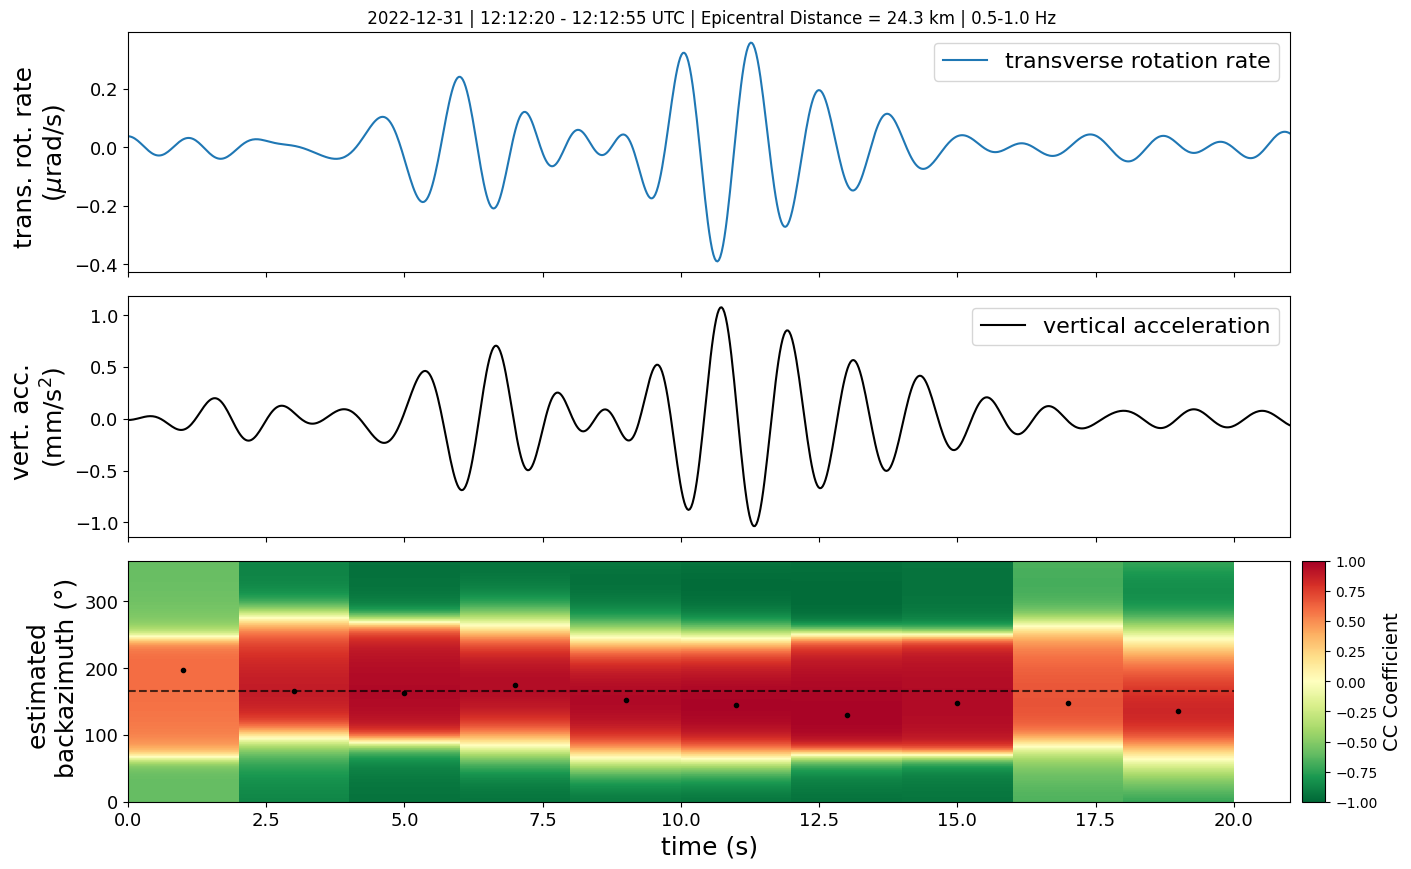

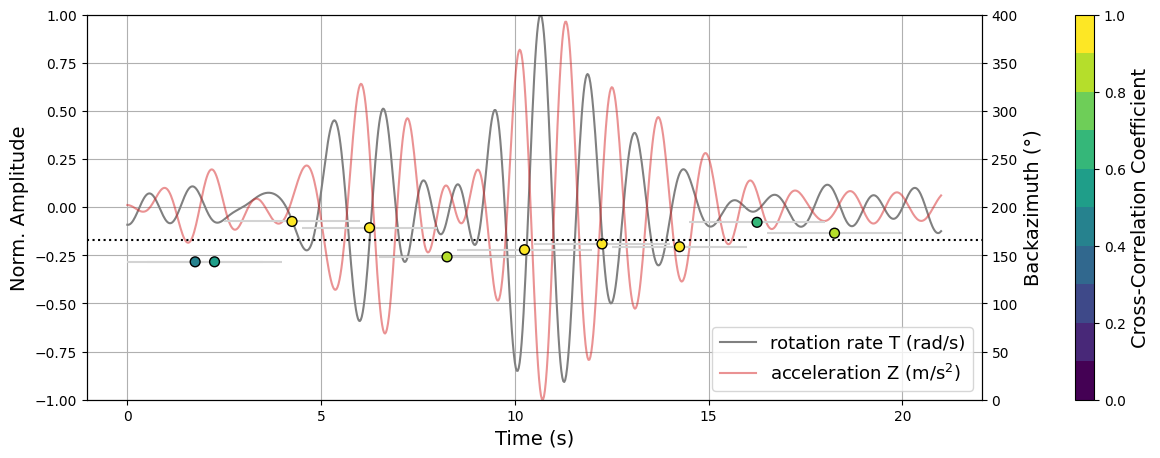

In [60]:
out1 = __compute_backazimuth(
                            acc,
                            rot,
                            config,
                            wave_type='love',
                            event=event,
                            plot=True,
                            flim=(fmin, fmax),
                            invert_rot_z=False,
                            show_details=False,
)

out1['fig'].savefig(config['path_to_figs']+f"BSPF_{name}_baz_love_{fmin}_{fmax}.png", dpi=150, bbox_inches='tight', pad_inches=0.05)


out2 = __compute_backazimuth(
                            acc,
                            rot,
                            config,
                            wave_type='rayleigh',
                            event=event,
                            plot=True,
                            flim=(fmin, fmax),
                            show_details=False,
)

out2['fig'].savefig(config['path_to_figs']+f"BSPF_{name}_baz_rayleigh_{fmin}_{fmax}.png", dpi=150, bbox_inches='tight', pad_inches=0.05)


out3 = __compute_backazimuth_tangent(
                                    rot,
                                    acc,
                                    win_time_s=config['win_length_sec'],
                                    overlap=config['overlap']/100,
                                    baz_theo=baz,
                                    cc_thres=0.1,
                                    plot=True,
                                    invert_acc_z=True,
                                    )

out3['fig'].savefig(config['path_to_figs']+f"BSPF_{name}_baz_tangent_{rot[0].stats.station}{fmin}_{fmax}.png", dpi=150, bbox_inches='tight', pad_inches=0.05)


In [73]:
def __compare_backazimuth_codes(rot0, acc0, cat_event, fmin, fmax, Twin, Toverlap, cc_thres=None, invert_acc_z=False, plot=False):

    import scipy.stats as sts
    import matplotlib.pyplot as plt

    from numpy import ones, linspace, histogram, concatenate, average, argmax, isnan, sqrt, cov, nan, array, arange
    from obspy import UTCDateTime
    from obspy.signal.rotate import rotate_ne_rt
    from functions.compute_backazimuth import __compute_backazimuth
    from functions.compute_backazimuth_tangent import __compute_backazimuth_tangent

    rot = rot0.copy()
    acc = acc0.copy()

    rot.detrend("demean").taper(0.01).filter("bandpass", freqmin=fmin, freqmax=fmax)
    acc.detrend("demean").taper(0.01).filter("bandpass", freqmin=fmin, freqmax=fmax)

    config = {}

    config['tbeg'] = rot[0].stats.starttime
    config['tend'] = rot[0].stats.endtime

    ## Eventtime
    config['eventtime'] = UTCDateTime(cat_event.origins[0].time)

    ## specify coordinates of station
    config['station_longitude'] =  -116.455439
    config['station_latitude']  = 33.6106

    ## specify window length for baz estimation in seconds
    config['win_length_sec'] = Twin

    ## define an overlap for the windows in percent (50 -> 50%)
    config['overlap'] = Toverlap

    ## specify steps for degrees of baz
    config['step'] = 1


    out1 = __compute_backazimuth(
                                acc,
                                rot,
                                config,
                                wave_type='rayleigh',
                                event=cat_event,
                                plot=False,
                                flim=(fmin, fmax),
                                show_details=False,
    )

    out2 = __compute_backazimuth(
                                acc,
                                rot,
                                config,
                                wave_type='love',
                                event=cat_event,
                                plot=False,
                                flim=(fmin, fmax),
                                show_details=False,
    )

    out3 = __compute_backazimuth_tangent(
                                        rot,
                                        acc,
                                        win_time_s= config['win_length_sec'],
                                        overlap=config['overlap']/100,
                                        baz_theo=out2['baz_theo'],
                                        cc_thres=0,
                                        plot=False,
                                        invert_acc_z=invert_acc_z,
    )

    ## filter according to cc-threshold
    if cc_thres:
        for ii, _cc in enumerate(out1['cc_max']):
            if abs(_cc) <= cc_thres:
                out1['cc_max'][ii], out1['cc_max_y'][ii] = nan, nan
        for ii, _cc in enumerate(out2['cc_max']):
            if abs(_cc) <= cc_thres:
                out2['cc_max'][ii], out2['cc_max_y'][ii] = nan, nan
        for ii, _cc in enumerate(out3['ccoef']):
            if abs(_cc) <= cc_thres:
                out3['ccoef'][ii], out3['baz_est'][ii] = nan, nan



    ## compute statistics
    deltaa = 10
    angles = arange(0, 365, deltaa)
    angles2 = arange(0, 365, 1)

    ## ______________________________________
    ## Rayleigh
    try:
        baz_rayleigh_no_nan = out1['cc_max_y'][~isnan(out1['cc_max_y'])]
        cc_rayleigh_no_nan = out1['cc_max'][~isnan(out1['cc_max'])]

        hist = histogram(out1['cc_max_y'], bins=len(angles)-1, range=[min(angles), max(angles)], weights=out1['cc_max'], density=True)

        baz_rayleigh_mean = round(average(baz_rayleigh_no_nan, weights=cc_rayleigh_no_nan), 0)
        baz_rayleigh_std = sqrt(cov(baz_rayleigh_no_nan, aweights=cc_rayleigh_no_nan))

        # baz_rayleigh_max = angles[argmax(hist[0])]+deltaa  ## add half of deltaa to be in the bin center
        kde1 = sts.gaussian_kde(baz_rayleigh_no_nan, weights=baz_rayleigh_no_nan)
        baz_rayleigh_max = angles2[argmax(kde1.pdf(angles2))]

        ## ______________________________________
        ## Love
        baz_love_no_nan = out2['cc_max_y'][~isnan(out2['cc_max_y'])]
        cc_love_no_nan = out2['cc_max'][~isnan(out2['cc_max'])]

        hist = histogram(out2['cc_max_y'], bins=len(angles)-1, range=[min(angles), max(angles)], weights=out2['cc_max'], density=True)

        baz_love_mean = round(average(baz_love_no_nan, weights=cc_love_no_nan), 0)
        baz_love_std = sqrt(cov(baz_love_no_nan, aweights=cc_love_no_nan))

        # baz_love_max = angles[argmax(hist[0])]+deltaa  ## add half of deltaa to be in the bin center
        kde2 = sts.gaussian_kde(baz_love_no_nan, weights=cc_love_no_nan)
        baz_love_max = angles2[argmax(kde2.pdf(angles2))]

        ## ______________________________________
        ## Tangent
        baz_tangent_no_nan = out3['baz_est'][~isnan(out3['ccoef'])]
        cc_tangent_no_nan = out3['baz_est'][~isnan(out3['ccoef'])]

        hist = histogram(out3['baz_est'], bins=len(angles)-1, range=[min(angles), max(angles)], weights=out3['ccoef'], density=True)

        baz_tangent_mean = round(average(baz_tangent_no_nan, weights=cc_tangent_no_nan), 0)
        baz_tangent_std = sqrt(cov(baz_tangent_no_nan, aweights=cc_tangent_no_nan))

        # baz_tangent_max = angles[argmax(hist[0])]+deltaa  ## add half of deltaa to be in the bin center
        kde3 = sts.gaussian_kde(baz_tangent_no_nan, weights=cc_tangent_no_nan)
        baz_tangent_max = angles2[argmax(kde3.pdf(angles2))]

    except Exception as e:
        print(e)
        pass

    if plot:

        import matplotlib.pyplot as plt
        from matplotlib.gridspec import GridSpec

        Ncol, Nrow = 8, 6

        fig3 = plt.figure(figsize=(12, 10))

        gs = GridSpec(Nrow, Ncol, figure=fig3, hspace=0.15)

        ax0 = fig3.add_subplot(gs[0, :])
        ax1 = fig3.add_subplot(gs[1, :])
        ax2 = fig3.add_subplot(gs[2, :])

        ax3 = fig3.add_subplot(gs[3, :])
        ax4 = fig3.add_subplot(gs[4, :])
        ax5 = fig3.add_subplot(gs[5, :])

        ax6 = fig3.add_subplot(gs[3, 7:])
        ax7 = fig3.add_subplot(gs[4, 7:])
        ax8 = fig3.add_subplot(gs[5, 7:])

        ax6.set_axis_off()
        ax7.set_axis_off()
        ax8.set_axis_off()

        for _ax in [ax0, ax1, ax2, ax3, ax4]:
            _ax.set_xticklabels([])

        rot_scaling, rot_unit = 1e6, r"$\mu$rad/s"
        trans_scaling, trans_unit = 1e3, r"mm/s$^2$"

        font = 12

        hz = acc.select(channel="*HZ")[0]
        hn = acc.select(channel="*HN")[0]
        he = acc.select(channel="*HE")[0]

        jz = rot.select(channel="*JZ")[0]
        jn = rot.select(channel="*JN")[0]
        je = rot.select(channel="*JE")[0]

        hr, ht = rotate_ne_rt(hn.data, he.data, out3['baz_theo'])
        jr, jt = rotate_ne_rt(jn.data, je.data, out3['baz_theo'])

        ## reverse polarity of transverse rotation!!
        # jt *= -1
        hr *= -1

        t1, t2 = hz.times().min(), hz.times().max()

        ax0.plot(hz.times(), (ht)*trans_scaling, 'black', label=f"PFO.T")
        ax1.plot(hz.times(), (hz.data)*trans_scaling, 'black', label=f"PFO.Z")
        ax2.plot(hz.times(), hr*trans_scaling, 'black', label=f"-1x PFO.R")

        ax0.set_ylim(-max(abs((ht)*trans_scaling)), max(abs((ht)*trans_scaling)))
        ax1.set_ylim(-max(abs((hz.data)*trans_scaling)), max(abs((hz.data)*trans_scaling)))
        ax2.set_ylim(-max(abs(hr*trans_scaling)), max(abs(hr*trans_scaling)))

        ax00 = ax0.twinx()
        ax00.plot(jz.times(), jz.data*rot_scaling, 'darkred', label=r"BSPF.Z")

        ax11 = ax1.twinx()
        ax11.plot(jz.times(), jt*rot_scaling, 'darkred', label=r"BSPF.T")

        ax22 = ax2.twinx()
        ax22.plot(jz.times(), jt*rot_scaling, 'darkred', label=r"BSPF.T")

        ax00.set_ylim(-max(abs(jz.data*rot_scaling)), max(abs(jz.data*rot_scaling)))
        ax11.set_ylim(-max(abs(jt*rot_scaling)), max(abs(jt*rot_scaling)))
        ax22.set_ylim(-max(abs(jt*rot_scaling)), max(abs(jt*rot_scaling)))

        cmap = plt.get_cmap("viridis", 10)

        ca3 = ax3.scatter(out1['cc_max_t'], out1['cc_max_y'], c=out1['cc_max'], s=50, cmap=cmap, edgecolors="k", lw=1, vmin=0, vmax=1, zorder=2)
        ca4 = ax4.scatter(out2['cc_max_t'], out2['cc_max_y'], c=out2['cc_max'], s=50, cmap=cmap, edgecolors="k", lw=1, vmin=0, vmax=1, zorder=2)
        ca5 = ax5.scatter(out3['t_win_center'], out3['baz_est'], c=out3['ccoef'], s=50, cmap=cmap, edgecolors="k", lw=1, vmin=0, vmax=1, zorder=2)

        cax3 = ax3.inset_axes([1.01, 0., 0.02, 1])
        cb3 = plt.colorbar(ca3, ax=ax3, cax=cax3)
        cb3.set_label("CC-Coeff.", fontsize=font)

        cax4 = ax4.inset_axes([1.01, 0., 0.02, 1])
        cb4 = plt.colorbar(ca4, ax=ax4, cax=cax4)
        cb4.set_label("CC-Coeff.", fontsize=font)

        cax5 = ax5.inset_axes([1.01, 0., 0.02, 1])
        cb5 = plt.colorbar(ca5, ax=ax5, cax=cax5)
        cb5.set_label("CC-Coeff.", fontsize=font)

        ax3.set_ylabel(f"Rayleigh BAz.(°)", fontsize=font)
        ax4.set_ylabel(f"Love BAz.(°)", fontsize=font)
        ax5.set_ylabel(f"CoVar. BAz.(°)", fontsize=font)

        ax66 = ax6.twinx()
        ax66.hist(out1['cc_max_y'], bins=len(angles)-1, range=[min(angles), max(angles)],
                  weights=out1['cc_max'], orientation="horizontal", density=True, color="grey")
        ax66.plot(kde1.pdf(angles), angles, c="k", lw=2, label='KDE')
        ax66.axhline(baz_rayleigh_max, color="k", ls="--")
        ax66.set_axis_off()
        ax66.yaxis.tick_right()
        ax66.invert_xaxis()

        ax77 = ax7.twinx()
        ax77.hist(out2['cc_max_y'], bins=len(angles)-1, range=[min(angles), max(angles)],
                  weights=out2['cc_max'], orientation="horizontal", density=True, color="grey")
        ax77.plot(kde2.pdf(angles), angles, c="k", lw=2, label='KDE')
        ax77.axhline(baz_love_max, color="k", ls="--")
        ax77.set_axis_off()
        ax77.yaxis.tick_right()
        ax77.invert_xaxis()

        ax88 = ax8.twinx()
        ax88.hist(out3['baz_est'], bins=len(angles)-1, range=[min(angles), max(angles)],
                  weights=out3['ccoef'], orientation="horizontal", density=True, color="grey")
        ax88.plot(kde3.pdf(angles), angles, c="k", lw=2, label='KDE')
        ax88.axhline(baz_tangent_max, color="k", ls="--")
        ax88.set_axis_off()
        ax88.yaxis.tick_right()
        ax88.invert_xaxis()


        ax0.set_yticks(linspace(ax0.get_yticks()[0], ax0.get_yticks()[-1], len(ax0.get_yticks())))
        ax00.set_yticks(linspace(ax00.get_yticks()[0], ax00.get_yticks()[-1], len(ax0.get_yticks())))

        ax1.set_yticks(linspace(ax1.get_yticks()[0], ax1.get_yticks()[-1], len(ax1.get_yticks())))
        ax11.set_yticks(linspace(ax11.get_yticks()[0], ax11.get_yticks()[-1], len(ax1.get_yticks())))

        ax2.set_yticks(linspace(ax2.get_yticks()[0], ax2.get_yticks()[-1], len(ax2.get_yticks())))
        ax22.set_yticks(linspace(ax22.get_yticks()[0], ax22.get_yticks()[-1], len(ax2.get_yticks())))

        for _ax in [ax0, ax1, ax2]:
            _ax.grid(which="both", ls=":", alpha=0.7, color="grey", zorder=0)
            _ax.legend(loc=1)
            _ax.set_ylabel(f"a ({trans_unit})", fontsize=font)
            _ax.set_xlim(0, (config['tend']-config['tbeg'])*1.15)
            _ax.xaxis.label.set_size(font-1)
            _ax.yaxis.label.set_size(font-1)

        for _ax in [ax3 ,ax4, ax5]:
            _ax.set_ylim(-5, 365)
            _ax.set_yticks(range(0, 360+60,60))
            _ax.grid(which="both", ls=":", alpha=0.7, color="grey", zorder=0)
            _ax.set_xlim(0,  (config['tend']-config['tbeg'])*1.15)
            _ax.xaxis.label.set_size(font-1)
            _ax.yaxis.label.set_size(font-1)

            _ax.plot([t1, t2], ones(2)*out3['baz_theo'], lw=1.5, alpha=0.7, color="k", ls="--", zorder=1)
            _ax.fill_between([t1, t2], ones(2)*out3['baz_theo']-10, ones(2)*out3['baz_theo']+10, lw=1.5, alpha=0.5, color="grey", zorder=1)

        for aaxx in [ax00, ax11, ax22]:
            aaxx.tick_params(axis='y', colors="darkred")
            aaxx.set_ylabel(f"$\Omega$ ({rot_unit})", color="darkred", fontsize=font)
            aaxx.legend(loc=4)
            _ax.xaxis.label.set_size(font-1)
            _ax.yaxis.label.set_size(font-1)

        ax0.set_title(f" {config['tbeg'].date}  {str(config['tbeg'].time).split('.')[0]}-{str(config['tend'].time).split('.')[0]} UTC | f = {fmin}-{fmax} Hz | T = {config['win_length_sec']} s | {config['overlap']} % overlap")

        ax5.set_xlabel("Time (s)", fontsize=font)

        plt.show();


    ## prepare output directory
    out = {}
    out['baz_theo'] = round(out2['baz_theo'], 0)
    out['baz_angles'] = angles
    out['baz_tangent_max'] = baz_tangent_max
    out['baz_tangent_mean'] = baz_tangent_mean
    out['baz_tangent_std'] = baz_tangent_std
    out['baz_rayleigh_max'] = baz_rayleigh_max
    out['baz_rayleigh_mean'] = baz_rayleigh_mean
    out['baz_rayleigh_std'] = baz_rayleigh_std
    out['baz_love_max'] = baz_love_max
    out['baz_love_mean'] = baz_love_mean
    out['baz_love_std'] = baz_love_std


    if plot:
        out['fig3'] = fig3

    return out

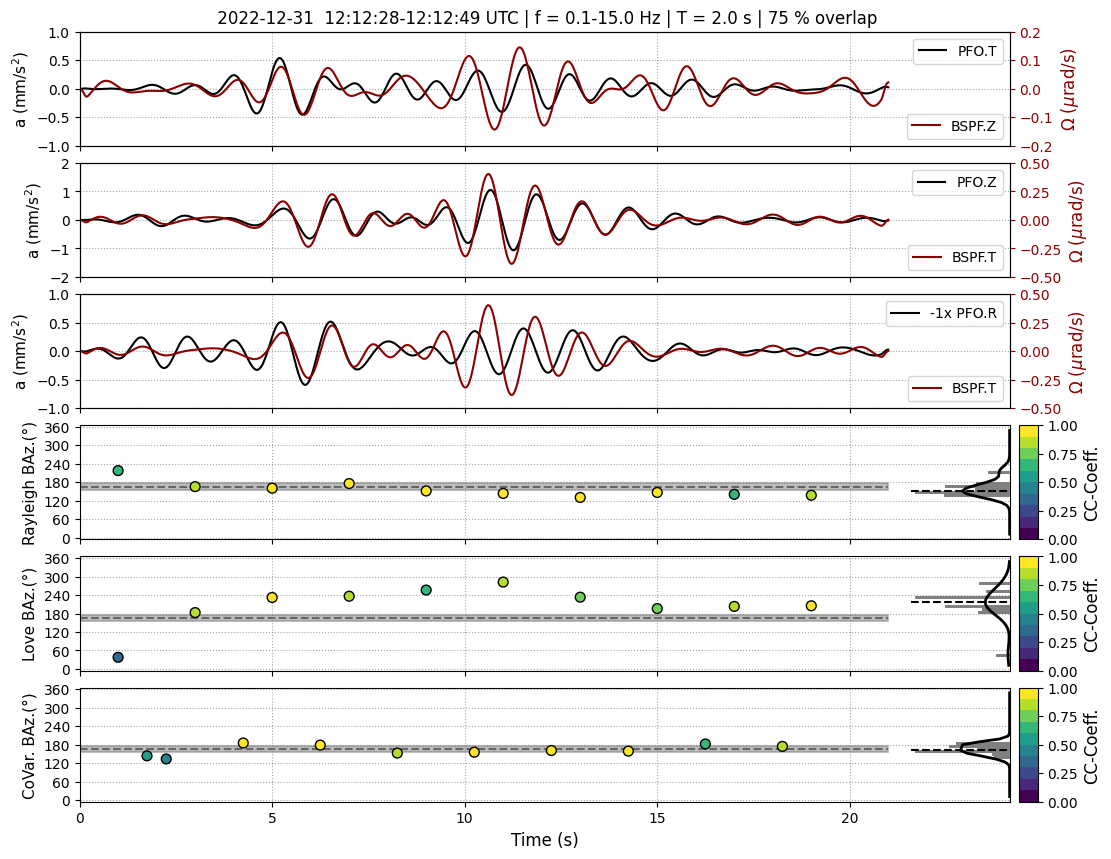

In [74]:
out4 = __compare_backazimuth_codes(rot, acc, event, fmin, fmax, config['win_length_sec'], config['overlap'], cc_thres=0.2, invert_acc_z=True, plot=True);

out4['fig3'].savefig(config['path_to_figs']+f"BSPF_{name}_baz_comparison_{rot[0].stats.location}_{fmin}_{fmax}_all.png", dpi=150, bbox_inches='tight', pad_inches=0.05);


## Compare backazimuth estimate for ADR, BSPF and Beamforming

In [77]:
from functions.compute_beamforming_pfo import __compute_beamforming_pfo

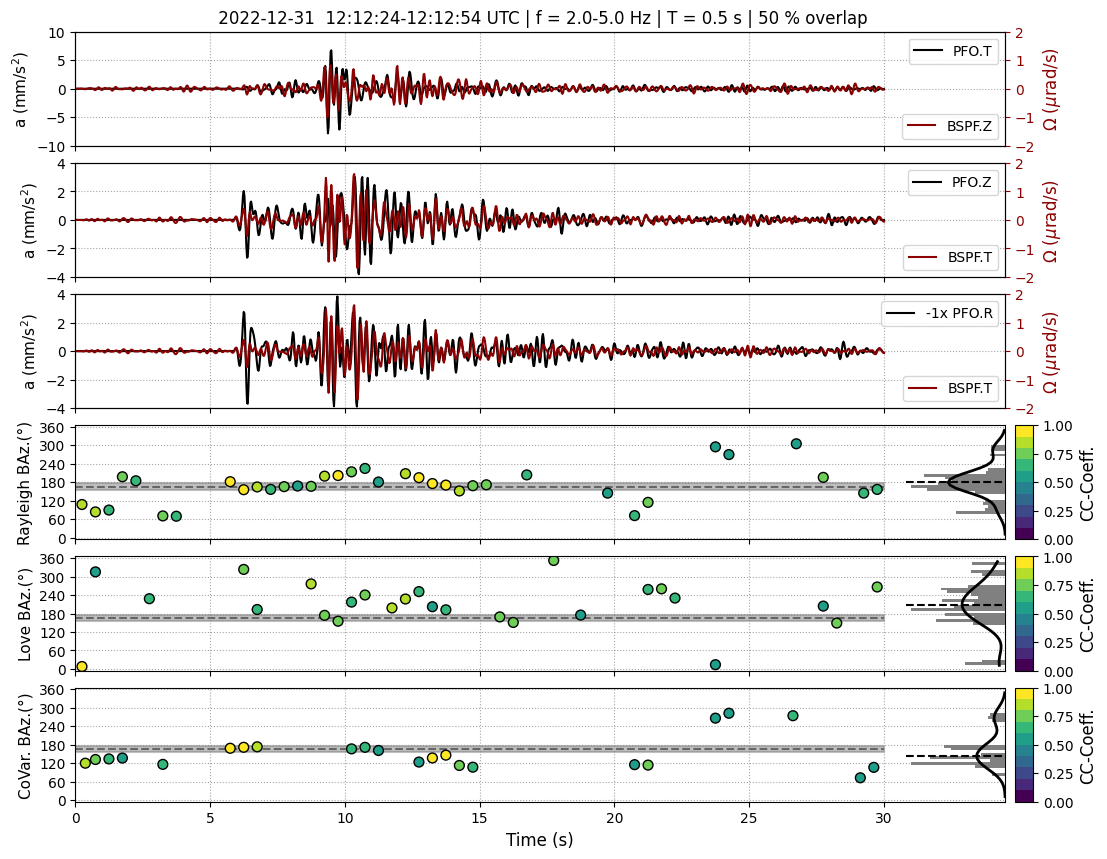

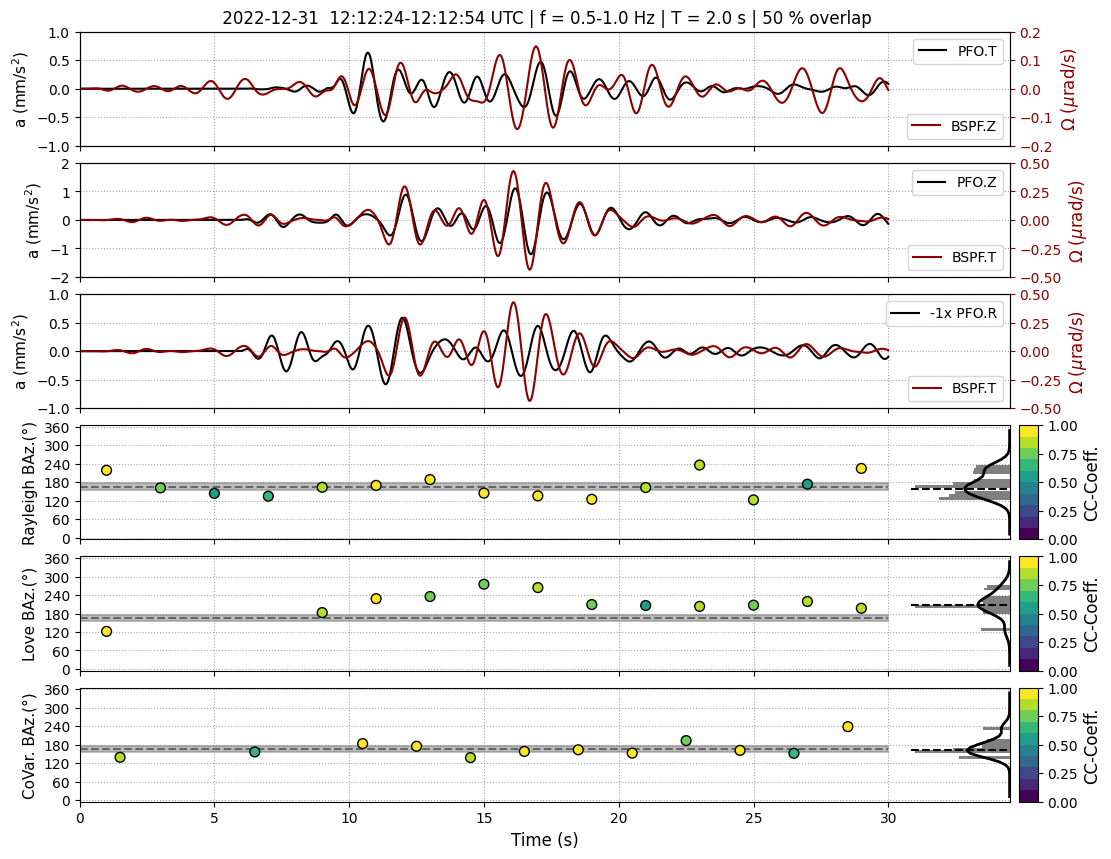

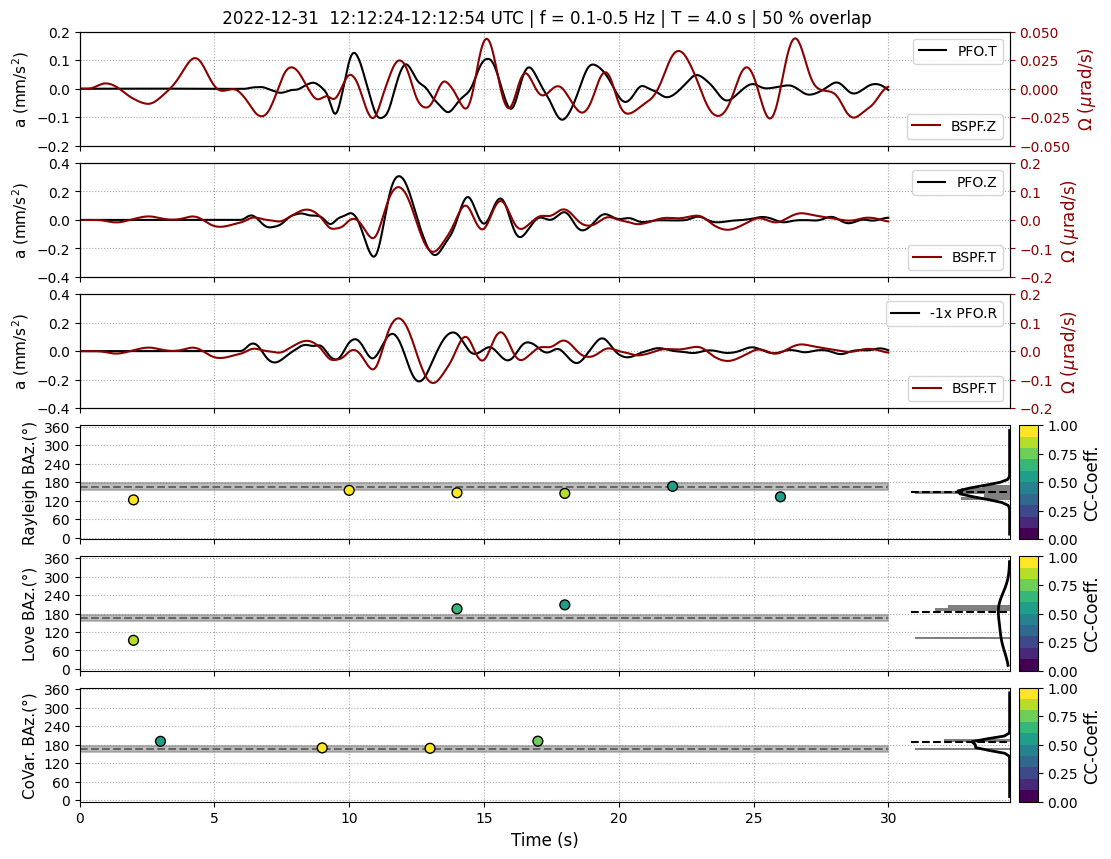

 -> obtained: 5 of 5 stations!

 -> Runtime: 0.3 minutes
 -> obtained: 8 of 8 stations!

 -> Runtime: 0.5 minutes
 -> obtained: 13 of 13 stations!

 -> Runtime: 0.76 minutes


In [78]:
stt = st0.copy();

acc0 = stt.copy().select(station="PFO*");
rot0 = stt.copy().select(station="BSPF");

for tr in acc0:
    if "Z" in tr.stats.channel:
        tr.data *= -1

cc_thres = 0.5

Twin_factor = 1
Twin_overlap = 50

## direct rotation
out_bspf_i = __compare_backazimuth_codes(rot0, acc0, event, 2.0, 5.0, Twin_factor/2.0, Twin_overlap,
                                         cc_thres=cc_thres, invert_acc_z=True, plot=True);
out_bspf_i['fig3'].savefig(config['path_to_figs']+f"BSPF_{name}_baz_comparison_{rot[0].stats.location}_2.0_5.0_all.png",
                           dpi=200, bbox_inches='tight', pad_inches=0.05);

out_bspf_m = __compare_backazimuth_codes(rot0, acc0, event, 0.5, 1.0, Twin_factor/0.5, Twin_overlap,
                                         cc_thres=cc_thres, invert_acc_z=True, plot=True);
out_bspf_m['fig3'].savefig(config['path_to_figs']+f"BSPF_{name}_baz_comparison_{rot[0].stats.location}_0.5_1.0_all.png",
                           dpi=200, bbox_inches='tight', pad_inches=0.05);

out_bspf_a = __compare_backazimuth_codes(rot0, acc0, event, 0.1, 0.5, Twin_factor/0.25, Twin_overlap,
                                         cc_thres=cc_thres, invert_acc_z=True, plot=True);
out_bspf_a['fig3'].savefig(config['path_to_figs']+f"BSPF_{name}_baz_comparison_{rot[0].stats.location}_0.1_0.5_all.png",
                           dpi=200, bbox_inches='tight', pad_inches=0.05);


## adr rotation
rot1 = stt.copy().select(station="RPFO", location="in");
out_adr_i = __compare_backazimuth_codes(rot1, acc0, event, 2.0, 5.0, Twin_factor/2.0, Twin_overlap,
                                        cc_thres=cc_thres, invert_acc_z=True, plot=False);

rot2 = stt.copy().select(station="RPFO", location="mi");
out_adr_m = __compare_backazimuth_codes(rot2, acc0, event, 0.5, 1.0, Twin_factor/0.5, Twin_overlap,
                                        cc_thres=cc_thres, invert_acc_z=True, plot=False);

rot3 = stt.copy().select(station="RPFO", location="al");
out_adr_a = __compare_backazimuth_codes(rot3, acc0, event, 0.1, 0.5, Twin_factor/0.25, Twin_overlap,
                                        cc_thres=cc_thres, invert_acc_z=True, plot=False);

## array beamforming
out_bf_i = __compute_beamforming_pfo(config['tbeg'], config['tend'], fmin=2.0, fmax=5.0, component="Z", submask="inner", plot=False)
out_bf_m = __compute_beamforming_pfo(config['tbeg'], config['tend'], fmin=0.5, fmax=1.0, component="Z", submask="mid", plot=False)
out_bf_a = __compute_beamforming_pfo(config['tbeg'], config['tend'], fmin=0.1, fmax=0.5, component="Z", submask="all", plot=False)
# out_bf_o = __compute_beamforming_pfo(config['tbeg'], config['tend'], fmin=0.8, fmax=1.0, component="Z", submask="mid", plot=False)


In [93]:
def __makeplot_comparison():

    labels = ["iBSPF", "iADR", "iBF", "mBSPF", "mADR", "mBF", "aBSPF", "aADR", "aBF"]

    fig, ax = plt.subplots(1, 1, figsize=(15, 5))

    font = 16

    ax.axhline(out_bspf_i['baz_theo'], color="k", ls="--", label="theo. Baz.")
    ax.fill_between([-0.3, 4.0], out_bspf_i['baz_theo']-10, out_bspf_i['baz_theo']+10, color="grey", alpha=0.5, label="theo. Baz. +- 10°")


    for j, out in enumerate([out_adr_i, out_adr_m, out_adr_a]):

        ax.errorbar(j-0.02, out['baz_tangent_max'], yerr=out['baz_tangent_std'], color="tab:blue", zorder=2)
        ax.errorbar(j, out['baz_love_max'], yerr=out['baz_love_std'], color="tab:green", zorder=2)
        ax.errorbar(j+0.02, out['baz_rayleigh_max'], yerr=out['baz_rayleigh_std'], color="tab:red", zorder=2)

        ax.scatter(j-0.02, out['baz_tangent_max'], color="tab:blue", zorder=2, label="Co.Var.", edgecolors="k")
        ax.scatter(j, out['baz_love_max'], color="tab:green", zorder=2, label="Love", edgecolors="k")
        ax.scatter(j+0.02, out['baz_rayleigh_max'], color="tab:red", zorder=2, label="Rayleigh", edgecolors="k")

        ## plot only for legend icon

        if j == 0:
            ax.scatter(j+0.4, out_bf_i['baz_bf_max'], color="tab:orange", zorder=2, label="beamforming", edgecolors="k")
            ax.legend(loc=1, fontsize=font-3)


    for j, out in enumerate([out_bspf_i, out_bspf_m, out_bspf_a]):

        ax.errorbar(j+0.18, out['baz_tangent_max'], yerr=out['baz_tangent_std'], color="tab:blue", zorder=2)
        ax.errorbar(j+0.2, out['baz_love_max'], yerr=out['baz_love_std'], color="tab:green", zorder=2)
        ax.errorbar(j+0.22, out['baz_rayleigh_max'], yerr=out['baz_rayleigh_std'], color="tab:red", zorder=2)

        ax.scatter(j+0.18, out['baz_tangent_max'], color="tab:blue", zorder=2, label="Co.Var.", edgecolors="k")
        ax.scatter(j+0.2, out['baz_love_max'], color="tab:green", zorder=2, label="Love", edgecolors="k")
        ax.scatter(j+0.22, out['baz_rayleigh_max'], color="tab:red", zorder=2, label="Rayleigh", edgecolors="k")


    for j, out in enumerate([out_bf_i, out_bf_m, out_bf_a]):

        ax.errorbar(j+0.4, out['baz_bf_max'], yerr=out['baz_bf_std'], color="tab:orange", zorder=2)
        ax.scatter(j+0.4, out['baz_bf_max'], color="tab:orange", zorder=2, label="", edgecolors="k")



    ax.set_xticks([0,0.2,0.4,1,1.2,1.4,2,2.2,2.4], labels=labels, fontsize=font-1)

    ax.grid(axis="y", ls=":", color="k", alpha=0.5, zorder=0)

    ax.text(0, 360+10, "2.0 - 5.0 Hz", fontsize=font-1)
    ax.text(1, 360+10, "0.5 - 1.0 Hz", fontsize=font-1)
    ax.text(2, 360+10, "0.1 - 0.5 Hz", fontsize=font-1)
    # ax.text(3, 360+10, "0.8 - 1.0 Hz", fontsize=font-1)

    ax.xaxis.label.set_size(font-1)
    ax.yaxis.label.set_size(font-1)

    ax.set_ylim(-5, 365)
    ax.set_yticks(range(0, 360+60,60))

    ax.set_ylabel("Backazimuth (°)", fontsize=font)

    ax.set_xlim(-0.3, 3.0)
    ax.set_ylim(0, 360)

    plt.show();
    return fig

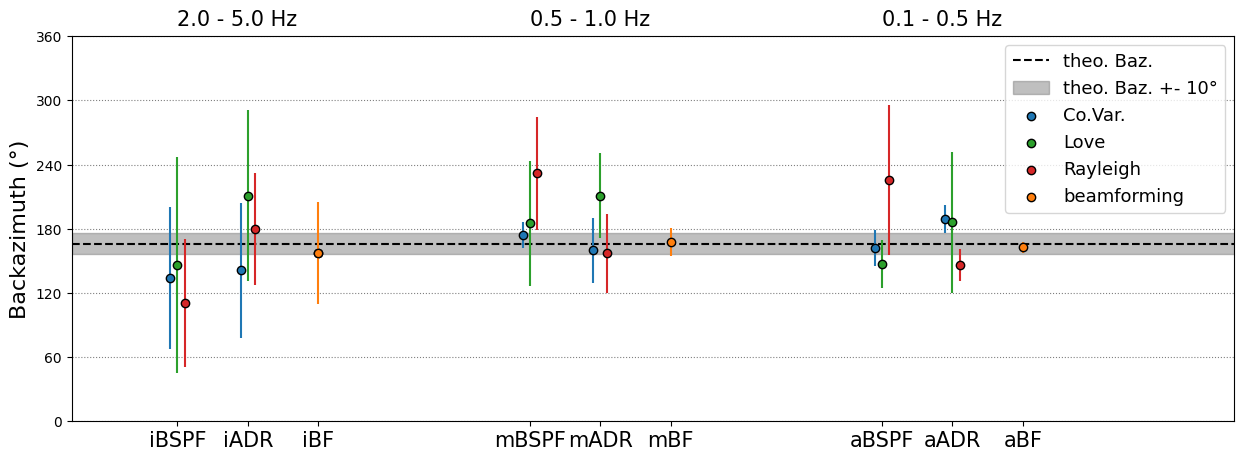

In [94]:
fig = __makeplot_comparison()

fig.savefig(config['path_to_figs']+f"BSPF_{name}_baz_comparison_overview.png", dpi=200, bbox_inches='tight', pad_inches=0.05);

In [ ]:
from functions.compute_cross_wavelet_transform import __compute_cross_wavelet_transform

In [ ]:
from obspy.signal.cross_correlation import correlate

In [ ]:
from functions.compute_wavelet_coherencey_transform import __compute_wavelet_coherency_transform

In [ ]:
# out_wct = __compute_wavelet_coherency_transform(
#                                             rot[0].times(),
#                                             rot.select(channel=f"*{comp}")[0].data,
#                                             adr.select(channel=f"*{comp}")[0].data,
#                                             rot[0].stats.delta,
#                                             fmax_limit=config['fmax'],
#                                             normalize=True,
#                                             plot=True,
# )

# out_wct['fig'].savefig(config['path_to_figs']+f"BSPF_M42_wct_{comp}_{config['fmin']}_{config['fmax']}.png", dpi=200, bbox_inches='tight', pad_inches=0.05)


## Coherence in Octaves

In [ ]:
from functions.makeplot_coherence_octaves import __coherence_in_octaves

In [65]:
def __coherence_in_octaves(st_in, fmin, fmax, normalize=False, plot=True):

    import matplotlib.pyplot as plt

    from matplotlib.gridspec import GridSpec
    from numpy import arange, mean, nan, nanmax, nanmean
    from pandas import DataFrame
    from functions.get_octave_bands import __get_octave_bands
    from scipy.signal import coherence

    flower, fupper, fcenter = __get_octave_bands(fmin, fmax, faction_of_octave=8, plot=False)

    fbands = [(fl, fu) for fl, fu in zip(flower, fupper)]

    colors = {"Z":"tab:red", "N":"tab:green", "E":"blue"}

    ## _____________________

#     ddf = 3
#     fcenter = arange(fmin+ddf, fmax-ddf, 1)
#     fbands = [(fc - ddf, fc + ddf) for fc in fcenter]

    out = {}

    if plot:
        NN = 5
        font = 12
        rot_scale, rot_unit, omega, sqrt_hz = 1e6, r"$\mu$rad/s" , r"$\Omega$", r"$\sqrt{Hz}$"

        fmin_i, fmax_i = 1.0, 6.0 ## 0.16, 16.5
        fmin_a, fmax_a = 0.5, 1.0  ## 0.02, 1.3


        fig = plt.figure(figsize=(15,14))

        gs = GridSpec(NN, 2, figure=fig)

        ax1 = fig.add_subplot(gs[0, :-1])
        ax2 = fig.add_subplot(gs[1, :-1])
        ax3 = fig.add_subplot(gs[2, :-1])

        ax4 = fig.add_subplot(gs[0, 1:])
        ax5 = fig.add_subplot(gs[1, 1:])
        ax6 = fig.add_subplot(gs[2, 1:])

        ax7 = fig.add_subplot(gs[3:, :])

        plt.subplots_adjust(hspace=0.2)



    for ii, comp in enumerate(["Z", "N", "E"]):

        tr0 = st_in.copy().select(station="BSPF", channel=f'*{comp}')[0]
        tr1 = st_in.copy().select(station="BSPF", channel=f'*{comp}')[0]
        tr2 = st_in.copy().select(station="RPFO", location="in", channel=f'*{comp}')[0]
        tr3 = st_in.copy().select(station="RPFO", location="mi", channel=f'*{comp}')[0]

        tr0 = tr0.detrend("linear").taper(0.01).filter("bandpass", freqmin=fmin_i, freqmax=fmax_i, corners=8, zerophase=True)
        tr1 = tr1.detrend("linear").taper(0.01).filter("bandpass", freqmin=fmin_a, freqmax=fmax_a, corners=8, zerophase=True)
        tr2 = tr2.detrend("linear").taper(0.01).filter("bandpass", freqmin=fmin_i, freqmax=fmax_i, corners=8, zerophase=True)
        tr3 = tr3.detrend("linear").taper(0.01).filter("bandpass", freqmin=fmin_a, freqmax=fmax_a, corners=8, zerophase=True)

        if normalize:
            tr0 = tr0.normalize()
            tr1 = tr1.normalize()
            tr2 = tr2.normalize()
            tr3 = tr3.normalize()
            rot_scale, rot_unit = 1, r"rad/s"

        co2, co3 = [], []
        for nn, (fl, fu) in enumerate(fbands):
            s0, s1, s2, s3 = tr0.copy(), tr1.copy(), tr2.copy(), tr3.copy()

            df = s1.stats.sampling_rate

            # tseg = 5/fl
            tseg = 20
            nseg = int(df*tseg) if int(df*tseg) < len(s1.data) else len(s1.data)
            nover = int(0.5*nseg)

            ff2, coh2 = coherence(s0.data, s2.data, fs=df, window='hann', nperseg=nseg, noverlap=nover)
            ff3, coh3 = coherence(s1.data, s3.data, fs=df, window='hann', nperseg=nseg, noverlap=nover)

#             ff2, coh2 = coherence(s1.data, s2.data, fs=df, window='hann')
#             ff3, coh3 = coherence(s1.data, s3.data, fs=df, window='hann')

            for i in range(len(ff2)):
                if ff2[i] <= fl or ff2[i] >= fu:
                    coh2[i], coh3[i] = nan, nan

            plt.semilogx(ff2, coh2)

            # co2.append(nanmax(coh2))
            # co3.append(nanmax(coh3))
            co2.append(nanmean(coh2))
            co3.append(nanmean(coh3))

        if plot:

            if comp == "Z":
                ax1.plot(tr0.times(), tr0.data*rot_scale, color="k", label=f"BSPF-{comp}")
                ax1.plot(tr2.times(), tr2.data*rot_scale, color=colors[comp], label=f"ADR-{comp}")

                ax4.plot(tr1.times(), tr1.data*rot_scale, color="k", label=f"BSPF-{comp}")
                ax4.plot(tr3.times(), tr3.data*rot_scale, color=colors[comp], label=f"ADR-{comp}")

            elif comp == "N":
                ax2.plot(tr0.times(), tr0.data*rot_scale, color="k", label=f"BSPF-{comp}")
                ax2.plot(tr2.times(), tr2.data*rot_scale, color=colors[comp], label=f"ADR-{comp}")

                ax5.plot(tr1.times(), tr1.data*rot_scale, color="k", label=f"BSPF-{comp}")
                ax5.plot(tr3.times(), tr3.data*rot_scale, color=colors[comp], label=f"ADR-{comp}")

            elif comp == "E":
                ax3.plot(tr0.times(), tr0.data*rot_scale, color="k", label=f"BSPF-{comp}")
                ax3.plot(tr2.times(), tr2.data*rot_scale,color=colors[comp], label=f"ADR-{comp}")

                ax6.plot(tr1.times(), tr1.data*rot_scale, color="k", label=f"BSPF-{comp}")
                ax6.plot(tr3.times(), tr3.data*rot_scale, color=colors[comp], label=f"ADR-{comp}")

            for ax in [ax1, ax2, ax3, ax4, ax5, ax6]:
                ax.legend(loc=1, ncol=2)
                ax.set_ylabel(f"{omega} ({rot_unit})", fontsize=font)

            ax7.scatter(fcenter, co2, s=40, marker="s", label="BSPF - RPFO_inner", zorder=2, color="w", edgecolors=colors[comp])
            ax7.plot(fcenter, co2, ls="-", color=colors[comp])

            ax7.scatter(fcenter, co3, s=40, label="BSPF - PRFO_mid", zorder=2, color="w", edgecolors=colors[comp])
            ax7.plot(fcenter, co3, ls=":", color=colors[comp])

            ax7.legend(loc=4, ncol=3)

            ax7.set_xscale("log")
            ax7.grid(ls="--", zorder=0, alpha=.5, which="both")

            ax7.set_xlabel("Frequency (Hz)", fontsize=font)
            # ax7.set_ylabel(f"Coherence ({rot_unit}/{sqrt_hz})", fontsize=font)
            ax7.set_ylabel(f"max. coherence per one-third-octave", fontsize=font)

            ax1.set_title(f"PRFO inner ({fmin_i} - {fmax_i} Hz)", fontsize=font)
            ax4.set_title(f"PRFO mid ({fmin_a} - {fmax_a} Hz)", fontsize=font)



        ## prepare output
        out[f'{comp}_in_fc'] = fcenter
        out[f'{comp}_in_co']  = co2
        out[f'{comp}_al_fc'] = fcenter
        out[f'{comp}_al_co']  = co3

    if plot:
        out['fig'] = fig
        plt.show();


    return out

In [66]:
st = st0.copy();

fmin, fmax = 0.1, 15.0

st.detrend("simple").taper(0.1).filter("bandpass", freqmin=fmin, freqmax=fmax)

# out_coh = __coherence_in_octaves(st, fmin, fmax, normalize=False, plot=True)

# out_coh['fig'].savefig(config['path_to_figs']+f"BSPF_M42_coherence.png", dpi=200, bbox_inches='tight', pad_inches=0.05)

15 Trace(s) in Stream:
II.PFO.10.BHE  | 2022-12-31T12:12:24.994538Z - 2022-12-31T12:12:54.994538Z | 40.0 Hz, 1201 samples
II.PFO.10.BHN  | 2022-12-31T12:12:24.994538Z - 2022-12-31T12:12:54.994538Z | 40.0 Hz, 1201 samples
II.PFO.10.BHZ  | 2022-12-31T12:12:24.994538Z - 2022-12-31T12:12:54.994538Z | 40.0 Hz, 1201 samples
II.RPFO.al.BJE | 2022-12-31T12:12:24.996349Z - 2022-12-31T12:12:54.996349Z | 40.0 Hz, 1201 samples
II.RPFO.al.BJN | 2022-12-31T12:12:24.996349Z - 2022-12-31T12:12:54.996349Z | 40.0 Hz, 1201 samples
II.RPFO.al.BJZ | 2022-12-31T12:12:24.996349Z - 2022-12-31T12:12:54.996349Z | 40.0 Hz, 1201 samples
II.RPFO.in.BJE | 2022-12-31T12:12:24.995468Z - 2022-12-31T12:12:54.995468Z | 40.0 Hz, 1201 samples
II.RPFO.in.BJN | 2022-12-31T12:12:24.995468Z - 2022-12-31T12:12:54.995468Z | 40.0 Hz, 1201 samples
II.RPFO.in.BJZ | 2022-12-31T12:12:24.995468Z - 2022-12-31T12:12:54.995468Z | 40.0 Hz, 1201 samples
II.RPFO.mi.BJE | 2022-12-31T12:12:24.996005Z - 2022-12-31T12:12:54.996005Z | 40.0 Hz, 

In [ ]:
def __crosscorrelation_in_octaves(st_in, fmin, fmax, normalize=False, plot=True):

    import matplotlib.pyplot as plt

    from matplotlib.gridspec import GridSpec
    from numpy import arange, mean, nan, nanmax
    from pandas import DataFrame
    from functions.get_octave_bands import __get_octave_bands
    from obspy.signal.cross_correlation import correlate

    flower, fupper, fcenter = __get_octave_bands(fmin, fmax, faction_of_octave=6, plot=False)

    fbands = [(fl, fu) for fl, fu in zip(flower, fupper)]

    colors = {"Z":"tab:red", "N":"tab:green", "E":"blue"}

    ## _____________________

    out = {}

    if plot:

        NN = 5
        font = 12
        rot_scale, rot_unit, omega, sqrt_hz = 1e6, r"$\mu$rad/s" , r"$\Omega$", r"$\sqrt{Hz}$"

        fmin_i, fmax_i = 1.0, 6.0 ## 0.16, 16.5
        fmin_a, fmax_a = 0.5, 1.0  ## 0.02, 1.3


        fig = plt.figure(figsize=(15,14))

        gs = GridSpec(NN, 2, figure=fig)

        ax1 = fig.add_subplot(gs[0, :-1])
        ax2 = fig.add_subplot(gs[1, :-1])
        ax3 = fig.add_subplot(gs[2, :-1])

        ax4 = fig.add_subplot(gs[0, 1:])
        ax5 = fig.add_subplot(gs[1, 1:])
        ax6 = fig.add_subplot(gs[2, 1:])

        ax7 = fig.add_subplot(gs[3:, :])

        plt.subplots_adjust(hspace=0.2)



    for ii, comp in enumerate(["Z", "N", "E"]):

        tr0 = st_in.copy().select(station="BSPF", channel=f'*{comp}')[0]
        tr1 = st_in.copy().select(station="BSPF", channel=f'*{comp}')[0]
        tr2 = st_in.copy().select(station="RPFO", location="in", channel=f'*{comp}')[0]
        tr3 = st_in.copy().select(station="RPFO", location="mi", channel=f'*{comp}')[0]

        tr0 = tr0.detrend("linear").taper(0.01).filter("bandpass", freqmin=fmin_i, freqmax=fmax_i, corners=4, zerophase=True)
        tr1 = tr1.detrend("linear").taper(0.01).filter("bandpass", freqmin=fmin_a, freqmax=fmax_a, corners=4, zerophase=True)
        tr2 = tr2.detrend("linear").taper(0.01).filter("bandpass", freqmin=fmin_i, freqmax=fmax_i, corners=4, zerophase=True)
        tr3 = tr3.detrend("linear").taper(0.01).filter("bandpass", freqmin=fmin_a, freqmax=fmax_a, corners=4, zerophase=True)


        cc2, cc3 = [], []
        for nn, (fl, fu) in enumerate(fbands):
            s0, s1, s2, s3 = tr0.copy(), tr1.copy(), tr2.copy(), tr3.copy()

            s0 = s0.detrend("linear").taper(0.01).filter("bandpass", freqmin=fl, freqmax=fu, corners=8, zerophase=True)
            s1 = s1.detrend("linear").taper(0.01).filter("bandpass", freqmin=fl, freqmax=fu, corners=8, zerophase=True)
            s2 = s2.detrend("linear").taper(0.01).filter("bandpass", freqmin=fl, freqmax=fu, corners=8, zerophase=True)
            s3 = s3.detrend("linear").taper(0.01).filter("bandpass", freqmin=fl, freqmax=fu, corners=8, zerophase=True)

            _cc2 = correlate(s0.data, s2.data, 0, demean=True, normalize='naive', method='fft')
            _cc3 = correlate(s1.data, s3.data, 0, demean=True, normalize='naive', method='fft')

            cc2.append(nanmax(_cc2))
            cc3.append(nanmax(_cc3))

        if plot:

            if comp == "Z":
                ax1.plot(tr0.times(), tr0.data*rot_scale, color="k", label=f"BSPF-{comp}")
                ax1.plot(tr2.times(), tr2.data*rot_scale, color=colors[comp], label=f"ADR-{comp}")

                ax4.plot(tr1.times(), tr1.data*rot_scale, color="k", label=f"BSPF-{comp}")
                ax4.plot(tr3.times(), tr3.data*rot_scale, color=colors[comp], label=f"ADR-{comp}")

            elif comp == "N":
                ax2.plot(tr0.times(), tr0.data*rot_scale, color="k", label=f"BSPF-{comp}")
                ax2.plot(tr2.times(), tr2.data*rot_scale, color=colors[comp], label=f"ADR-{comp}")

                ax5.plot(tr1.times(), tr1.data*rot_scale, color="k", label=f"BSPF-{comp}")
                ax5.plot(tr3.times(), tr3.data*rot_scale, color=colors[comp], label=f"ADR-{comp}")

            elif comp == "E":
                ax3.plot(tr0.times(), tr0.data*rot_scale, color="k", label=f"BSPF-{comp}")
                ax3.plot(tr2.times(), tr2.data*rot_scale,color=colors[comp], label=f"ADR-{comp}")

                ax6.plot(tr1.times(), tr1.data*rot_scale, color="k", label=f"BSPF-{comp}")
                ax6.plot(tr3.times(), tr3.data*rot_scale, color=colors[comp], label=f"ADR-{comp}")

            for ax in [ax1, ax2, ax3, ax4, ax5, ax6]:
                ax.legend(loc=1, ncol=2)
                ax.set_ylabel(f"{omega} ({rot_unit})", fontsize=font)

            ax7.scatter(fcenter, cc2, s=20, marker="s", label="BSPF - RPFO_inner", zorder=2, color="w", edgecolors=colors[comp])
            ax7.plot(fcenter, cc2, ls="-", color=colors[comp])

            ax7.scatter(fcenter, cc3, s=20, label="BSPF - PRFO_mid", zorder=2, color="w", edgecolors=colors[comp])
            ax7.plot(fcenter, cc3, ls=":", color=colors[comp])

            ax7.legend(loc=3, ncol=3)

            ax7.set_xscale("log")
            ax7.grid(ls="--", zorder=0, alpha=.5, which="both")

            ax7.set_xlabel("Frequency (Hz)", fontsize=font)
            # ax7.set_ylabel(f"Coherence ({rot_unit}/{sqrt_hz})", fontsize=font)
            ax7.set_ylabel(f"max. coherence per one-third-octave", fontsize=font)

            ax1.set_title(f"PRFO inner ({fmin_i} - {fmax_i} Hz)", fontsize=font)
            ax4.set_title(f"PRFO mid ({fmin_a} - {fmax_a} Hz)", fontsize=font)

            ax7.set_ylim(-1, 1)


        ## prepare output
        out[f'{comp}_in_fc'] = fcenter
        out[f'{comp}_in_cc']  = cc2
        out[f'{comp}_al_fc'] = fcenter
        out[f'{comp}_al_cc']  = cc3

    if plot:
        out['fig'] = fig
        plt.show();


    return out

In [ ]:
st = st0.copy();

for tr in st:
    if "BSPF" in tr.stats.station:
        tr.data = np.roll(tr.data, 3)


fmin, fmax = 0.1, 15.0

st.detrend("demean").taper(0.1).filter("bandpass", freqmin=fmin, freqmax=fmax)

out_coh = __crosscorrelation_in_octaves(st, fmin, fmax, normalize=False, plot=True)

out_coh['fig'].savefig(config['path_to_figs']+f"BSPF_M42_crosscorrelation_octaves.png", dpi=200, bbox_inches='tight', pad_inches=0.05)

## Cross Spectral Density

In [ ]:
from functions.makeplotStream_csd import __makeplotStream_csd

In [ ]:
# fig = __makeplotStream_csd(st0, config);

In [ ]:
def __makeplotStream_coherence(sti, config):

    from scipy import fftpack
    from matplotlib.gridspec import GridSpec
    from scipy.signal import coherence
    from numpy import array, log10

    import matplotlib.pyplot as plt

    st = sti.copy()

    NN = 5
    rot_scaling, rot_unit = 1e6, r"$\mu$rad/s"
    trans_scaling, trans_unit = 1e6, r"$\mu$m/s"

#     rot_scaling, rot_unit = 1, r"nrad/s"
#     trans_scaling, trans_unit = 1, r"$\mu$m/s"

    colors2 = ['darkred', 'darkgreen', 'magenta', 'tab:green', 'red', 'lightgreen']
#     colors2 = ['crimson', 'darkblue', 'red', '#3776ab', 'magenta', 'indigo']

    fig = plt.figure(figsize=(15, 14))

    gs = GridSpec(NN, 2, figure=fig)

    ax1 = fig.add_subplot(gs[0, :-1])
    ax2 = fig.add_subplot(gs[1, :-1])
    ax3 = fig.add_subplot(gs[2, :-1])

    ax4 = fig.add_subplot(gs[0, 1:])
    ax5 = fig.add_subplot(gs[1, 1:])
    ax6 = fig.add_subplot(gs[2, 1:])

    ax7 = fig.add_subplot(gs[3:, :])


    font = 14

    plt.subplots_adjust(hspace=0.1)

    ## _______________________________________________

#     st.normalize()

    st.sort(keys=['channel'], reverse=True)

    bspf_all_data, bspf_inner_data, adr_all_data, adr_inner_data = [],[],[],[]

    names, ffs, csds, ffs2, csds2 = [], [], [], [], []

    for comp in ["Z", "N", "E"]:

        tmp = st.select(channel=f"*{comp}")
        print(tmp)

        bspf_inner = tmp[0].copy()
        bspf_inner.detrend("linear")
        bspf_inner.taper(0.1)
        bspf_inner.filter("bandpass", freqmin=1, freqmax=6, corners=4, zerophase=True)
        bspf_inner.normalize()

        adr_inner = tmp[1].copy()
        adr_inner.detrend("linear")
        adr_inner.taper(0.1)
        adr_inner.filter("bandpass", freqmin=1, freqmax=6, corners=4, zerophase=True)
        adr_inner.normalize()

        nseg = int(5*tmp[0].stats.sampling_rate)


        ff, Pxy = coherence(
                            bspf_inner.data,
                            adr_inner.data,
                            fs=bspf_inner.stats.sampling_rate,
                            nperseg=nseg,
                            window='hann',
                            noverlap=int(0.5*nseg),
                            nfft=None,
                            detrend='constant',
                            axis=-1,
                        )

        names.append(f"{tmp[0].stats.channel}"+r"$_{inner}$")
        ffs.append(ff)
        csds.append(Pxy)

        adr_inner_data.append(adr_inner.data)
        bspf_inner_data.append(bspf_inner.data)

        ## _____________________________________

        bspf_all = tmp[0].copy()
        bspf_all.detrend("linear")
        bspf_all.taper(0.1)
        bspf_all.filter("bandpass", freqmin=0.5, freqmax=1.0, corners=4, zerophase=True)
        bspf_all.normalize()

        adr_all = tmp[2].copy()
        adr_all.detrend("linear")
        adr_all.taper(0.1)
        adr_all.filter("bandpass", freqmin=0.5, freqmax=1.0, corners=4, zerophase=True)
        adr_all.normalize()

        nseg = int(20*tmp[0].stats.sampling_rate)

        ff2, Pxy2 = coherence(
                            bspf_all.data*rot_scaling,
                            adr_all.data*rot_scaling,
                            fs=bspf_all.stats.sampling_rate,
                            nperseg=nseg,
                            window='hann',
                            noverlap=int(0.5*nseg),
                            nfft=None,
                            detrend='constant',
                            axis=-1,
                        )

        names.append(f"{tmp[0].stats.channel}"+r"$_{all}$")

        ffs.append(ff2)
        csds.append(Pxy2)

        adr_all_data.append(adr_all.data)
        bspf_all_data.append(bspf_all.data)

    hz = st.select(channel="B*Z")[0]
    hn = st.select(channel="B*N")[0]
    he = st.select(channel="B*E")[0]

    jz = st.select(channel="HJZ")[0]
    jn = st.select(channel="HJN")[0]
    je = st.select(channel="HJE")[0]

    ax1.plot(hz.times(), bspf_all_data[0], 'black', label=f"BSPF.Z")
    ax2.plot(hn.times(), bspf_all_data[1], 'black', label=f"BSPF.N")
    ax3.plot(he.times(), bspf_all_data[2], 'black', label=f"BSPF.E")
    ax1.plot(hz.times(), adr_all_data[0], 'darkred', label=r"ADR$_{all}$.Z")
    ax2.plot(hn.times(), adr_all_data[1], 'darkred', label=r"ADR$_{all}$.N")
    ax3.plot(he.times(), adr_all_data[2], 'darkred', label=r"ADR$_{all}$.E")

    ax4.plot(jz.times(), bspf_inner_data[0], 'black', label=f"BSPF.Z")
    ax5.plot(jn.times(), bspf_inner_data[1], 'black', label=f"BSPF.N")
    ax6.plot(je.times(), bspf_inner_data[2], 'black', label=f"BSPF.E")
    ax4.plot(jz.times(), adr_inner_data[0], 'darkred', label=r"ADR$_{inner}$.Z")
    ax5.plot(jn.times(), adr_inner_data[1], 'darkred', label=r"ADR$_{inner}$.N")
    ax6.plot(je.times(), adr_inner_data[2], 'darkred', label=r"ADR$_{inner}$.E")


    for ii, (ff, cc, name) in enumerate(zip(ffs, csds, names)):
#         ax7.plot(ff, 20*log10(abs(cc)), label=name[2:], alpha=0.6, color=colors2[ii])
        if "all" in name:
            ax7.plot(ff, abs(cc), label=name[2:], alpha=0.6, color=colors2[ii])
        elif "inner" in name:
            if "Z" in name:
                ax8 = ax7.twinx()
            ax8.plot(ff, abs(cc), label=name[2:], alpha=0.6, color=colors2[ii])


#     ax7.set_yscale("log")

    for ax in [ax1, ax2, ax3, ax4 ,ax5, ax6]:
        ax.legend(loc=1, fontsize=font-2, bbox_to_anchor=(0.95, 1.10), ncol=2)
        ax.set_ylabel(f"$\omega$ ({rot_unit})", fontsize=font)
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        ax.spines['bottom'].set_visible(False)
        if ax not in [ax3, ax6]:
            ax.set(xticklabels=[])
            ax.tick_params(bottom=False)

    ax7.set_xscale("log")
    ax7.grid(which="both", ls=":", alpha=0.7, color="grey")
    ax7.legend(fontsize=font-2, ncol=3, loc=2)
    ax7.set_xlim(0.3, 10)
    ax7.set_xlabel("Frequency (Hz)", fontsize=font)
    sqrthz=r"$\sqrt{Hz}$"
#     ax7.set_ylabel(f"Cross Spectral Density \n (dB rel. to 1 nrad$^2$/s$^2$/Hz)", fontsize=font)
    ax7.set_ylabel(f"Cross Spectral Density ({rot_unit}/{sqrthz}')", fontsize=font)


    ax8.legend(fontsize=font-2, ncol=3, loc=1)
    ax8.set_ylabel(f"Cross Spectral Density ({rot_unit}/{sqrthz}')", fontsize=font, color="tab:red")
    ax8.tick_params(axis='y', colors='tab:red')

    ax3.set_xlabel("Time (s)", fontsize=font)
    ax6.set_xlabel("Time (s)", fontsize=font)


    bbox = list(ax7.get_position().bounds)
    bbox[3] = .85*bbox[3] # Reduce the height of the axis a bit.
    ax7.set_position(bbox)

    for ax in [ax1, ax2, ax3, ax4 ,ax5, ax6, ax7, ax8]:
        ax.tick_params(axis="y", labelsize=font-2)
        ax.tick_params(axis="x", labelsize=font-2)

#     axes[i,0].ticklabel_format(axis='y', style='sci', scilimits=(0,0))
#     axes[i,1].ticklabel_format(axis='y', style='sci', scilimits=(0,0))

    return fig

In [ ]:
fig = __makeplotStream_coherence(st0, config);

## Phase Velocity

In [ ]:
from functions.compute_velocity_from_amplitude_ratio import __compute_velocity_from_amplitude_ratio

In [ ]:
from functions.makeplot_velocities import __makeplotStream_velocities

In [ ]:
acc = st0.select(station="PFO*").copy();
rot = st0.select(station="BSPF").copy();
# rot = st0.select(station="RPFO", location="mi").copy()

fmin, fmax = 0.5, 1.0

rot.detrend("demean").taper(0.1).filter("bandpass", freqmin=fmin, freqmax=fmax, zerophase=True, corners=4);
acc.detrend("demean").taper(0.1).filter("bandpass", freqmin=fmin, freqmax=fmax, zerophase=True, corners=4);


In [ ]:
fig = __makeplotStream_velocities(rot, acc, fmin, fmax, baz,
                                  overlap=0.5, cc_threshold=0.2,
                                  reverse_rotZ=False, reverse_accZ=True,
                                 );

fig.savefig(config['path_to_figs']+f"BSPF_M42_velocities_{rot[0].stats.station}_{fmin}_{fmax}.png", dpi=200, bbox_inches='tight', pad_inches=0.05)


In [ ]:
# out = __compute_velocity_from_amplitude_ratio(
#                                                 rot,
#                                                 acc,
#                                                 baz=baz,
#                                                 mode='love',
#                                                 win_time_s=1/fmin,
#                                                 cc_thres=0.5,
#                                                 overlap=0.9,
#                                                 flim=(fmin, fmax),
#                                                 plot=True,
# )

# out['fig'].savefig(config['path_to_figs']+f"BSPF_M42_velocity_love_{rot[0].stats.station}_{fmin}_{fmax}.png", dpi=200, bbox_inches='tight', pad_inches=0.05)


# out = __compute_velocity_from_amplitude_ratio(
#                                                 rot,
#                                                 acc,
#                                                 baz=baz,
#                                                 mode='rayleigh',
#                                                 win_time_s=1/fmin,
#                                                 cc_thres=0.5,
#                                                 overlap=0.9,
#                                                 flim=(fmin, fmax),
#                                                 plot=True,
# )

# out['fig'].savefig(config['path_to_figs']+f"BSPF_M42_velocity_rayleigh_{rot[0].stats.station}_{fmin}_{fmax}.png", dpi=200, bbox_inches='tight', pad_inches=0.05)


# 

### Velocity in F-Bands

In [ ]:
def __estimate_velocity_in_fbands(st0):

    from functions.get_octave_bands import __get_octave_bands

    flower, fupper, fcenter = __get_octave_bands(0.5, 6, faction_of_octave=3, plot=False)

    fbands = [(f1, f2) for f1, f2 in zip(flower, fupper)]


    # fbands = [(0.5,0.7), (0.7,0.9), (0.8,1.0), (1.0,2.0), (1.0,5.0), (3.0,8.0), (5.0,12.0)]

    love_velo, rayl_velo = [], []
    r_flabels, l_flabels = [], []

    velo = np.arange(0, 5000, 250)


    for fmin, fmax in fbands:


        fmin, fmax = round(fmin, 2), round(fmax, 2)
        print(fmin, fmax)

        acc = st0.select(station="PFO").copy();
        rot = st0.select(station="BSPF").copy();

        # rot = st0.select(station="RPFO", location="al").copy();
        # rot = st0.select(station="RPFO", location="mi").copy();
        # rot = st0.select(station="RPFO", location="in").copy();

        rot.select(channel="*Z")[0].data *= -1

        rot = rot.detrend("simple").taper(0.01).filter("bandpass", freqmin=fmin, freqmax=fmax, zerophase=True, corners=4);
        acc = acc.detrend("simple").taper(0.01).filter("bandpass", freqmin=fmin, freqmax=fmax, zerophase=True, corners=4);

        cc_threshold = 0.7
        overlap = 0.9

        out_l = __compute_velocity_from_amplitude_ratio(
                                                        rot,
                                                        acc,
                                                        baz=baz,
                                                        mode='love',
                                                        win_time_s=2/fmin,
                                                        cc_thres=cc_threshold,
                                                        overlap=overlap,
                                                        flim=(fmin, fmax),
                                                        plot=True,
        )

        lvel = out_l['velocity'][~np.isnan(out_l['velocity'])]

        if len(lvel) > 2:
            hist = np.histogram(out_l['velocity'], bins=len(velo)-1, range=[min(velo), max(velo)], weights=(out_l['ccoef']*100).astype(int), density=False)
            data = np.concatenate([np.ones(int(nnn))*val for nnn, val in zip(hist[0], hist[1])], axis=0 )
            love_velo.append(data)
            l_flabels.append(f"{round(fmin,1)}-{round(fmax,1)}Hz")



        out_r = __compute_velocity_from_amplitude_ratio(
                                                        rot,
                                                        acc,
                                                        baz=baz,
                                                        mode='rayleigh',
                                                        win_time_s=2/fmin,
                                                        cc_thres=cc_threshold,
                                                        overlap=overlap,
                                                        flim=(fmin, fmax),
                                                        plot=True,
        )

        rvel = out_r['velocity'][~np.isnan(out_r['velocity'])]

        if len(rvel) > 2:
            hist = np.histogram(out_r['velocity'],
                                bins=len(velo)-1,
                                range=[min(velo), max(velo)],
                                weights=(out_r['ccoef']*100).astype(int),
                                density=False,
                               )

            data = np.concatenate([np.ones(int(nnn))*val for nnn, val in zip(hist[0], hist[1])], axis=0 )

            rayl_velo.append(data)

            r_flabels.append(f"{round(fmin,1)}-{round(fmax,1)}Hz")


    #     plt.figure()
    #     plt.hist(out_l['velocity'], bins=len(velo)-1, range=[min(velo), max(velo)], weights=out_l['ccoef'], density=False, rwidth=0.9)
    #     plt.show();

    #     plt.figure()
    #     plt.hist(out_r['velocity'], bins=len(velo)-1, range=[min(velo), max(velo)], weights=out_r['ccoef'], density=False, rwidth=0.9)
    #     plt.show();


    fig1, ax = plt.subplots(1, 1, figsize=(15,5))

    data = love_velo

    ax.yaxis.grid(True)
    ax.violinplot(data, showmeans=False, showmedians=True, showextrema=True)

    ax.set_ylabel("Love Phase Velocity (m/s)")
    ax.set_xticks([y + 1 for y in range(len(data))], labels=l_flabels)

    if rot[0].stats.station == "RPFO":
        ax.set_title(f" {acc[0].stats.station} - {rot[0].stats.station}{rot[0].stats.location[0]} | Overlap = {int(overlap*100)} % | CC_limit = {cc_threshold}")
    else:
        ax.set_title(f" {acc[0].stats.station} - {rot[0].stats.station} | Overlap = {int(overlap*100)} % | CC_limit = {cc_threshold}")


    plt.show();




    fig2, ax = plt.subplots(1, 1, figsize=(15,5))

    data = rayl_velo

    ax.yaxis.grid(True)
    out2 = ax.violinplot(data, showmeans=False, showmedians=True, showextrema=True)

    ax.set_ylabel("Rayleigh Phase Velocity (m/s)")
    ax.set_xticks([y + 1 for y in range(len(data))], labels=r_flabels)

    if rot[0].stats.station == "RPFO":
        ax.set_title(f" {acc[0].stats.station} - {rot[0].stats.station}{rot[0].stats.location[0]} | Overlap = {int(overlap*100)} % | CC_limit = {cc_threshold}")
    else:
        ax.set_title(f" {acc[0].stats.station} - {rot[0].stats.station} | Overlap = {int(overlap*100)} % | CC_limit = {cc_threshold}")

    plt.show();
    return fig1, fig2

In [ ]:
st = st0.copy()

fig1, fig2 = __estimate_velocity_in_fbands(st)


fig1.savefig(config['path_to_figs']+f"BSFP_M42_Love_velocity_fbands_{rot[0].stats.station}.png", format="png", dpi=200, bbox_inches='tight')

fig2.savefig(config['path_to_figs']+f"BSFP_M42_Rayleigh_velocity_fbands_{rot[0].stats.station}_{rot[0].stats.location}.png", format="png", dpi=200, bbox_inches='tight')

## BAZ in F-Bands ??

In [ ]:
def __estimate_baz_in_fbands():

    # flower, fupper, fcenter = __get_octave_bands(0.5, 10, fband_type="one-third-octave", plot=False)
    flower, fupper, fcenter = __get_octave_bands(0.5, 10, fband_type="octave", plot=False)
    fbands = [(f1, f2) for f1, f2 in zip(flower, fupper)]


    # fbands = [(0.5,0.7), (0.7,0.9), (0.8,1.0), (1.0,2.0), (1.0,5.0), (3.0,8.0)]

    backazis = []
    flabels = []

    angles = np.arange(0, 365, 5)

    for fmin, fmax in fbands:

        print(fmin, fmax)

        acc = st0.select(station="PFO").copy();
        rot = st0.select(station="BSPF").copy();
        # rot = st0.select(station="RPFO").copy();

        rot = rot.detrend("demean").taper(0.01).filter("bandpass", freqmin=fmin, freqmax=fmax, zerophase=True, corners=8);
        acc = acc.detrend("demean").taper(0.01).filter("bandpass", freqmin=fmin, freqmax=fmax, zerophase=True, corners=8);

        win_time_s = 1/fmin
        cc_threshold = 0.2
        overlap = 0.9



        out3 = __compute_backazimuth_tangent(
                                            rot,
                                            acc,
                                            win_time_s=win_time_s,
                                            overlap=overlap,
                                            baz_theo=None,
                                            cc_thres=cc_threshold,
                                            plot=False,
        )


        if len(out3['baz_est']) > 0:
            hist = np.histogram(out3['baz_est'], bins=len(angles)-1, range=[min(angles), max(angles)], weights=(out3['ccoef']*100).astype(int), density=False)
            dat = np.concatenate([np.ones(int(nnn))*val for nnn, val in zip( hist[0], hist[1])], axis=0 )
            backazis.append(dat)
            flabels.append(f"{round(fmin,1)}-{round(fmax,1)}Hz")
        else:
            print(f"empty results")


    fig, ax = plt.subplots(1, 1, figsize=(15,5))


    ax.yaxis.grid(True)

    ax.violinplot(backazis, showmeans=False, showmedians=True, showextrema=True)

    ax.set_ylabel("Rayleigh Phase Velocity (m/s)")
    ax.set_xticks([y + 1 for y in range(len(data))], labels=flabels)

    ax.set_title(f" {acc[0].stats.station} - {rot[0].stats.station} | Overlap = {int(overlap*100)} % | CC_limit = {cc_threshold}")

    ax.set_ylim(0, 360)

    # fig.savefig(config['path_to_figs']+f"BSFP_Rayleigh_velocity_fbands_{rot[0].stats.station}.png", format="png", dpi=200, bbox_inches='tight')

    plt.show();

# __estimate_baz_in_fbands()